# Оценка результатов A/B-теста. 
В наше распоряжение предоставлены:
- датасет с действиями пользователей
- техническое задание 
- несколько вспомогательных датасетов.

Оценим корректность проведения теста и проанализируем его результаты.


**Техническое задание**
- Название теста: `recommender_system_test`
- Группы: 
  - А (контрольная)
  - B (новая платёжная воронка)
- Дата запуска: 2020-12-07;
- Дата остановки набора новых пользователей: 2020-12-21;
- Дата остановки: 2021-01-04;
- Ожидаемое количество участников теста: 15% новых пользователей из региона EU
- Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы
- Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
 - конверсии в просмотр карточек товаров — событие `product_page`
 - просмотры корзины — событие `product_cart`
 - покупки — событие `purchase` .



**В исследовании:**
- Оценим корректность проведения теста
- Изучим данные о пользовательской активности
- Определим и проверим корректность горизонта анализа
- Оценим распределение количества событий на пользователя в разрезе групп теста

**Ход исследования:**
- Загрузка данных из предоставленных файлов 
- Изучение общей информации о датафрейме и предобработка данных
- Выяснение наличия пользователей, участвующих в двух группах теста одновременно.
- Изучение данных о пользовательской активности
- Исследовательский анализ данных:
- Оценку результатов A/B-тестирования
- Выводы по этапу исследовательского анализа данных и по оценке результатов A/B-тестирования.





## Загрузка и подготовка данных к анализу

Загрузим данные о гипотезах, заказах и пользователях интернет-магазина из CSV-файлов в переменные.

**Пути к файлам**


|Описание набора данных |Присвоение датафрейму наименования |Путь к файлу |
|:-----|:----|----:|
- календарь маркетинговых событий на 2020 год: |marketing_events|[Скачать датасет](ххх);
- все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года:|users| [Скачать датасет](ххх);
- все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года:|clients_events| [Скачать датасет](ххх);
- таблица участников тестов:|participants| [Скачать датасет](ххх);

Изучим данные и выполним предобработку. Есть ли в данных пропуски и дубликаты? Убедимся, что типы данных во всех колонках соответствуют сохранённым в них значениям. Обратим внимание на столбцы с датой и временем.


### Импортируем библиотеки:
- **pandas**  
- **matplotlib** - для построения графиков 
- **IPython.display** для отображения данных 
- **numpy** для отображения размерностей графиков и диаграмм
- **datetime** для работы с данными в формате даты и времени
- **scipy** для расчета статистических тестов
- **warnings** для отключения предупреждений
- **from plotly import graph_objects as go** для построения графика воронки

In [259]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np
from datetime import datetime, timedelta
import math as mth
from scipy import stats as st

import scipy.stats as stats
import datetime as dt
import warnings
from plotly import graph_objects as go

### Загрузим данные из csv-файла.

Сохраним данные в переменную **data**.  
В качестве разделителя столбцов используем соответствиующий файлу тип - **\t**

### Загрузим данные из csv-файлов.

Сохраним данные в переменную **data**.  
В качестве разделителя столбцов используем соответствиующий файлу тип - ```sep = ','```, используем его по умолчанию.

In [260]:
try:
    marketing_events = pd.read_csv('C:/Users/Александр/Downloads/ab_project_marketing_events.csv')
    users = pd.read_csv('C:/Users/Александр/Downloads/final_ab_new_users.csv')
    clients_events = pd.read_csv('C:/Users/Александр/Downloads/final_ab_events.csv')
    participants = pd.read_csv('C:/Users/Александр/Downloads/final_ab_participants.csv')
    print("Файлы загружены с Локального диска")    
    
except:
    marketing_events = pd.read_csv('xxx')
    users = pd.read_csv('xxx')
    clients_events = pd.read_csv('xxx')
    participants = pd.read_csv('xxx')
    print("Файлы загружены из ЛК ЯП")      


Файлы загружены из ЛК ЯП


### Выведем основную информацию о датафреймах и ознакомимся с ней

Поскольку в исследовании используются несколько датафреймов, то для ознакомления с информацией в них создадим небольшую функцию `acquaintance` 

In [261]:
def acquaintance (df):
    print("\033[34m""\033[1m""Первые строки датафрейма")
    display(df.head(5))
    print("\033[34m""\033[1m""Информация о типах данных")
    print()
    display(df.info())
    print("\033[34m""\033[1m""Доля пропущенных значений ")
    display(round(df.isna().mean() * 100).astype(int))
    return

#### Календарь маркетинговых событий на 2020 год. 
Заказчик сообщил нам структуру файла ` ab_project_marketing_events.csv ` (мы сохранили его для исследования под именем  ` marketing_events `):

| | | |
|:-----|:----|----:| 
name | название маркетингового события| | 
regions | регионы, в которых будет проводиться рекламная кампания| |
start_dt | дата начала кампании| | 
finish_dt | дата завершения кампании| | 

  
Выведем первые строки датафрейма, информацию о типах данных и о пропусках  

In [262]:
acquaintance(marketing_events)

Первые строки датафрейма


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


None

Доля пропущенных значений 


name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

#### Все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года. 
Заказчик сообщил нам структуру файла `final_ab_new_users` (мы сохранили его для исследования под именем `users`):

| | | |
|:-----|:----|----:| 
user_id | идентификатор пользователя| | 
first_date | дата регистрации| | 
region | регион пользователя| | 
device | устройство, с которого происходила регистрация| |


  
Выведем первые строки датафрейма, информацию о типах данных и о пропусках  

In [263]:
acquaintance(users)

Первые строки датафрейма


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


None

Доля пропущенных значений 


user_id       0
first_date    0
region        0
device        0
dtype: int64

#### Все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

Заказчик сообщил нам структуру файла `final_ab_events` (мы сохранили его для исследования под именем  `clients_events`):

| | | |
|:-----|:----|----:| 
user_id | идентификатор пользователя| | 
event_dt | дата и время события| | 
event_name | тип события| | 
details | дополнительные данные о событии. Например, для покупок, purchase , в этом поле хранится стоимость покупки в долларах| |



  
Выведем первые строки датафрейма, информацию о типах данных и о пропусках  

In [264]:
acquaintance(clients_events)

Первые строки датафрейма


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,1e+02
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


None

Доля пропущенных значений 


user_id        0
event_dt       0
event_name     0
details       86
dtype: int64

#### Таблица участников тестов

Заказчик сообщил нам структуру файла `final_ab_participants` (мы сохранили его для исследования под именем  `participants`):

| | | |
|:-----|:----|----:| 
user_id | идентификатор пользователя| | 
ab_test | название теста| | 
group | группа пользователя| |



  
Выведем первые строки датафрейма, информацию о типах данных и о пропусках  

In [265]:
acquaintance(participants)

Первые строки датафрейма


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Информация о типах данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


None

Доля пропущенных значений 


user_id    0
group      0
ab_test    0
dtype: int64

In [266]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])
marketing_events['duration'] = marketing_events['finish_dt'] - marketing_events['start_dt']
marketing_events.info()
marketing_events.sort_values('start_dt')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   name       14 non-null     object         
 1   regions    14 non-null     object         
 2   start_dt   14 non-null     datetime64[ns] 
 3   finish_dt  14 non-null     datetime64[ns] 
 4   duration   14 non-null     timedelta64[ns]
dtypes: datetime64[ns](2), object(2), timedelta64[ns](1)
memory usage: 688.0+ bytes


,name,regions,start_dt,finish_dt,duration
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07,13 days
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,2 days
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,2 days
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,2 days
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,7 days
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,2 days
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11,2 days
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01,6 days
4,4th of July Promo,N.America,2020-07-04,2020-07-11,7 days
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07,6 days


In [267]:
print(
    ' Названия уникальных событий при посещении сайта - ',clients_events['event_name'].unique(),'\n',
    'Названия уникальных регионов - ',users['region'].unique(),'\n',
    'Названия уникальных устройств - ',users['device'].unique(),'\n',
    'Названия уникальных групп пользователей при проведении теста - ', participants['group'].unique(),'\n',
    'Названия уникальных тестов - ', participants['ab_test'].unique(),'\n',
    'Самая ранняя дата начала кампании - ', pd.to_datetime(marketing_events['start_dt']).min(),'\n',
    'Самая поздняя дата начала кампании - ', pd.to_datetime(marketing_events['start_dt']).max(),'\n',
    'Самая ранняя дата регистрации пользователя - ', pd.to_datetime(users['first_date']).min(),'\n',
    'Самая поздняя дата регистрации пользователя - ', pd.to_datetime(users['first_date']).max(),'\n',
    'Самая ранняя дата события новых пользователей - ', pd.to_datetime(clients_events['event_dt']).min(),'\n',
    'Самая поздняя дата события новых пользователей - ', pd.to_datetime(clients_events['event_dt']).max()
)

 Названия уникальных событий при посещении сайта -  ['purchase' 'product_cart' 'product_page' 'login'] 
 Названия уникальных регионов -  ['EU' 'N.America' 'APAC' 'CIS'] 
 Названия уникальных устройств -  ['PC' 'Android' 'iPhone' 'Mac'] 
 Названия уникальных групп пользователей при проведении теста -  ['A' 'B'] 
 Названия уникальных тестов -  ['recommender_system_test' 'interface_eu_test'] 
 Самая ранняя дата начала кампании -  2020-01-25 00:00:00 
 Самая поздняя дата начала кампании -  2020-12-30 00:00:00 
 Самая ранняя дата регистрации пользователя -  2020-12-07 00:00:00 
 Самая поздняя дата регистрации пользователя -  2020-12-23 00:00:00 
 Самая ранняя дата события новых пользователей -  2020-12-07 00:00:33 
 Самая поздняя дата события новых пользователей -  2020-12-30 23:36:33


### Краткие выводы об основной информации в датафреймах 
- Данные о датах представлены в формате object - далее мы приведем их к формату даты и времени.  
- Названия столбцов представлены по правилам "хорошего тона".
- В датафрейме `clients_events` пропущены 86% записей в столбце `details` - поскольку в этом столбце Заказчик указывает (имеющиеся) дополнительные данные о событии, то мы принимаем, что строки с отсутствующими данными не требуют обработки.
- В исследуемый промежуток времени было проведено 14 маркетинговых мероприятий (событий)
- Период проведения маркетинговых мероприятий - полный 2020 год - с 2020-01-25 по 2020-12-30
- Маркетинговые мероприятия проводильсь по крайней мере в четырех регионах
- В датафрейме `users` данные представлены за период с 7 по 23 декабря 2020 года, а по условию исследования Дата остановки набора новых пользователей: 2020-12-21.
- В период с 7 по 23 декабря 2020 года в интернет-магазине зарегистрировались 61733 пользователя
- В указанный период пользователи регистрировались с четырех типов устройств из четырех регионов
- В датафрейме `clients_events` данные представлены за период с 7 по 30 декабря 2020 года, а по условию исследования должны присутствовать события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
- В датафрейме `clients_events`  представлены данные о 440317 событиях, из которых 62740 дополнены данными о событиях
- В датафрейме `clients_events`  представлены 4 вида событий: 
 - 'login'- вход
 - 'product_page' - просмотр карточек товаров
 - 'product_cart' - просмотры корзины
 - 'purchase' - покупки 
- В проведенном А/В тесте приняли участие 18268 пользователей, разделенных на две группы
- Представлены данные о двух различных А/В тестах - `recommender_system_test` и `interface_eu_test`. По условию задания Название теста: `recommender_system_test`
  
**Таким образом предоставленных данных достаточно большое количество, чтобы провести анализ.**

Но сначала проведем предварительную обработку данных

In [268]:
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


## Предварительная обработка данных.

### Приведем данные в столбцах с датами к формату дата-время (datetime).

При ознакомлении с данными мы уже привели к формату datetime столбцы `start_dt` и `finish_dt` в датафрейме `marketing_events`.  
Сейчас проведем аналогичное действие для данных с датами в файлах `users` и `clients_events`.

In [269]:
users['first_date'] = pd.to_datetime(users['first_date'])

clients_events['event_dt'] = pd.to_datetime(clients_events['event_dt'])

### Приведем набор данных в датафрейме `users` к заявленному в исследовании периоду и региону
Вспомним, что в датафрейме `users` данные представлены за период с 7 по 23 декабря 2020 года, а по условию исследования Дата остановки набора новых пользователей: 2020-12-21.   
Оставим в датафрейме данные только за период с 7 по 21 декабря 2020 года включительно   
Также данные представлены по пользователям из четырех регионов. По условиям задания нас интресуют пользователи, зарегистрированные в регионе `EC`.<br>   
В датафрейме мы оставим только пользователей, зарегистрированные в регионе `EC` - но сделаем это несколько позже


In [270]:
users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [271]:
#users = users.query('first_date <= "2020-12-21" and region == "EU"')
users = users.query('first_date <= "2020-12-21"')
print(
    ' Самая ранняя дата регистрации пользователя - ', users['first_date'].min(),'\n',
    'Самая поздняя дата регистрации пользователя - ', users['first_date'].max(),'\n',
    'Названия уникальных регионов - ',users['region'].unique()
)

 Самая ранняя дата регистрации пользователя -  2020-12-07 00:00:00 
 Самая поздняя дата регистрации пользователя -  2020-12-21 00:00:00 
 Названия уникальных регионов -  ['EU' 'N.America' 'APAC' 'CIS']


### Приведем набор данных в датафрейме `participants` к заявленному в исследовании названию теста

Вспомним также, что в датафрейме `participants` представлены данные о двух различных А/В тестах - `recommender_system_test` и `interface_eu_test`. По условию задания Название теста: `recommender_system_test`.\
Оставим в датафрейме данные только о тесте `recommender_system_test`.\
Для последующей проверки сохраним исходные данные в датафрейме `participants_original`

In [272]:
participants_original = participants

In [273]:
participants_original['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [274]:
len_incom_participants = len(participants)
participants = participants.query('ab_test == "recommender_system_test"')

print(
    'Названия уникальных тестов - ', participants['ab_test'].unique(), '\n',
    "Количество удаленных строк - ", len_incom_participants - len(participants), '\n',
    "Количество оставшихся строк - ", len(participants)
)

Названия уникальных тестов -  ['recommender_system_test'] 
 Количество удаленных строк -  11567 
 Количество оставшихся строк -  6701


### Выявим и при необходимости удалим дубликаты

In [275]:
def find_duplicates(data_name, name):
    print(f"Количество полных дубликатов в датафрейме \'{name}\': ", data_name.duplicated().sum())
    return#(data_name.duplicated().sum())

In [276]:
find_duplicates(marketing_events, 'marketing_events')
find_duplicates(users, 'users')
find_duplicates(clients_events, 'clients_events')
find_duplicates(participants, 'participants')

Количество полных дубликатов в датафрейме 'marketing_events':  0
Количество полных дубликатов в датафрейме 'users':  0
Количество полных дубликатов в датафрейме 'clients_events':  0
Количество полных дубликатов в датафрейме 'participants':  0


### Выявим неявные дубликаты

Проверим количество уникальных `user_id`и сравним его с количеством строк в датафрейме `users`. 
Убедимся, что в обоих случая одно и то же значение - 61733

In [277]:
users['user_id'].nunique()

56470

Проверим наличие дубликатов в столюце `user_id` дататфрейма `participants`

In [278]:
participants[['user_id']].duplicated().sum()

0

### Проверим соответствие ожидаемого количества участников теста
По заданию ожидаемое количество участников теста: 15% новых пользователей из региона EU;   
Проверим, составляет ли количество пользователей из целевого региона, попавших в тест, 15% от общего числа пользователей из целевого региона, зарегистрированных в период набора пользователей в тест 

In [279]:
# общее числа пользователей из целевого региона, зарегистрированных в период набора пользователей в тест = len(users)

# общее количество пользователей из целевого региона, попавших в тест = len(participants)

# соотношение указанных выше показалетей:
len(participants) /  len(users)

0.11866477775810165

Видим, что количество участников теста составляет 11,8% что не соответствует  ожидаемому количеству - 15%.   
Но подождем делать выводы - проведем предварительную обработку данных до конца

### Проверим, присутствует ли один и тот же клиент в разных группах.

In [280]:
print(
    ' Количество уникальных пользователей ВСЕГО  - ', len(participants['user_id'].unique()), '\n',
    'Количество уникальных пользователей в группе A - '
          , len(participants['user_id'].loc[(participants['group'] == "A")].unique()), '\n',
    'Количество уникальных пользователей в группе B - '
          , len(participants['user_id'].loc[(participants['group'] == "B")].unique()), '\n',
    'Суммарное количество уникальных пользователей в обеих группах - '
          , len(participants['user_id'].loc[(participants['group'] == "A")].unique())
          + len(participants['user_id'].loc[(participants['group'] == "B")].unique()) , '\n',
    "Разница в количестве уникальных пользователей в группах - "
          , abs(
              round(1- len(participants['user_id'].loc[(participants['group'] == "A")].unique())
          / len(participants['user_id'].loc[(participants['group'] == "B")].unique()), 3)
                   )
)

 Количество уникальных пользователей ВСЕГО  -  6701 
 Количество уникальных пользователей в группе A -  3824 
 Количество уникальных пользователей в группе B -  2877 
 Суммарное количество уникальных пользователей в обеих группах -  6701 
 Разница в количестве уникальных пользователей в группах -  0.329


Отметим, что всего в базе представлено 6701 уникальных клиентов и Суммарное количество уникальных пользователей в обеих группах также составляет 6701 клиентов.   
Таким образом у нас:
- исключено присутствие одних и тех же клиентов  одновременно в обеих группах
- отсутствуют клиенты, не отнесенные ни к какой группе
- разница в количестве пользователей в группах теста составляет 32,9%

Сохраним в переменную `users_in_test` список пользователей, отобранных в тест

In [281]:
users_in_test = participants['user_id'].to_list()


Сохраним в переменную `participants_in_users` список пользователей из датафрейма `users`, отобранных в тест

Функцией `categorize_customers` создадим в датафрейме `users` столбец `user_is_in_caterory`, куда отнесем признак `присутствует`  пользователям из списка `users_in_test` и признак `не присутствует` остальным пользователям

In [282]:
def categorize_customers(total_income):
    mobils = users_in_test
    for cheq in range(len(mobils)):
        for mobil in mobils:
            if total_income == mobil:
                return 'присутствует'
        else:
            return 'не присутствует'
        
users['user_is_in_caterory'] = users['user_id'].apply(categorize_customers)
users.head()

/tmp/ipykernel_49/2304508527.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_id,first_date,region,device,user_is_in_caterory
0,D72A72121175D8BE,2020-12-07,EU,PC,присутствует
1,F1C668619DFE6E65,2020-12-07,N.America,Android,не присутствует
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC,не присутствует
3,50734A22C0C63768,2020-12-07,EU,iPhone,не присутствует
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone,не присутствует


In [283]:
participants_in_users = users.query('user_is_in_caterory == "присутствует"').sort_values('user_id')
participants_in_users

,user_id,first_date,region,device,user_is_in_caterory
18045,000ABE35EE11412F,2020-12-08,EU,PC,присутствует
59654,001064FEAAB631A1,2020-12-20,EU,Android,присутствует
39334,0010A1C096941592,2020-12-17,EU,Android,присутствует
35860,001C05E87D336C59,2020-12-10,EU,iPhone,присутствует
13791,00341D8401F0F665,2020-12-21,EU,iPhone,присутствует
...,...,...,...,...,...
34300,FFC2C5F898D1245B,2020-12-10,EU,Android,присутствует
51520,FFC53FD45DDA5EE8,2020-12-19,EU,iPhone,присутствует
19124,FFE858A7845F005E,2020-12-08,EU,PC,присутствует
18060,FFED90241D04503F,2020-12-08,EU,Android,присутствует


Увидим, что в переменной `participants_in_users` 6701 строк - столько содержит список `users_in_test`.   
И вспомним сейчас, что ранее мы отложили удаление из датафрейма `users` пользователей, зарегистрированных не в регионе `EU`.  
Сейчас время объяснить - почему мы отлжили это действие.  
Выведем из переменной `participants_in_users` пользователей, зарегистрированных не в регионе `EU` - поместим их в переменную `error_users`.

In [284]:
error_users = participants_in_users.query('region != "EU"')
error_users

,user_id,first_date,region,device,user_is_in_caterory
19415,0178FA423606B54B,2020-12-08,N.America,Android,присутствует
28370,01C17F099908DA14,2020-12-09,N.America,PC,присутствует
37368,01E9662F25EE4560,2020-12-17,CIS,PC,присутствует
27617,01FBAA6FD2342365,2020-12-09,N.America,PC,присутствует
3868,03F889B99919FBF1,2020-12-07,N.America,Android,присутствует
...,...,...,...,...,...
13270,FC5CFDAC95C1223B,2020-12-21,N.America,Android,присутствует
7533,FD7FBBF2324D52B1,2020-12-14,N.America,iPhone,присутствует
56761,FD8541358AFC6B7D,2020-12-13,N.America,Android,присутствует
16176,FEA10D53EE8882D3,2020-12-21,N.America,PC,присутствует


Таковых оказалось 350 пользователей. Напомним, что эти 350 пользователей зачислены в датафрейм `participants` - в который по условию теста попадают лишь пользователи, зарегистрированные в регионе `EU` - а, стало быть, попали они в датафрейм `participants` ошибочно.   
Поэтому вот сейчас мы:
- удалим из датафрейма `users` пользователей, зарегистрированных не в регионе `EU`.
- удалим из датафрейма `participants` пользователей, зарегистрированных не в регионе `EU` - то есть тех, которые в переменной `participants_in_users` не принадлежат региону `EU`.

In [285]:
users = users.query('first_date <= "2020-12-21" and region == "EU"')
participants_in_users = participants_in_users.query('region == "EU"')
participants_in_users

,user_id,first_date,region,device,user_is_in_caterory
18045,000ABE35EE11412F,2020-12-08,EU,PC,присутствует
59654,001064FEAAB631A1,2020-12-20,EU,Android,присутствует
39334,0010A1C096941592,2020-12-17,EU,Android,присутствует
35860,001C05E87D336C59,2020-12-10,EU,iPhone,присутствует
13791,00341D8401F0F665,2020-12-21,EU,iPhone,присутствует
...,...,...,...,...,...
34300,FFC2C5F898D1245B,2020-12-10,EU,Android,присутствует
51520,FFC53FD45DDA5EE8,2020-12-19,EU,iPhone,присутствует
19124,FFE858A7845F005E,2020-12-08,EU,PC,присутствует
18060,FFED90241D04503F,2020-12-08,EU,Android,присутствует


Заметим, что в датафрейме `users` осталось 6351 пользователей.  
350 пользователей, отобранных для теста в группы `А` и `В` датафрейма `participants`,  зарегистрированных не в регионе `EU` - удалены из переменной

In [286]:
error_users_id = error_users['user_id'].to_list()


In [287]:
def categorize_users_in_participants(total_income):
    mobils = error_users_id
    for cheq in range(len(mobils)):
        for mobil in mobils:
            if total_income == mobil:
                return 'присутствует'
        else:
            return 'не присутствует'
        
participants['user_is_in_caterory'] = participants['user_id'].apply(categorize_users_in_participants)
participants

/tmp/ipykernel_49/4239839824.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_id,group,ab_test,user_is_in_caterory
0,D1ABA3E2887B6A73,A,recommender_system_test,не присутствует
1,A7A3664BD6242119,A,recommender_system_test,не присутствует
2,DABC14FDDFADD29E,A,recommender_system_test,не присутствует
3,04988C5DF189632E,A,recommender_system_test,не присутствует
4,482F14783456D21B,B,recommender_system_test,не присутствует
...,...,...,...,...
6696,053FB26D6D49EDDC,A,recommender_system_test,присутствует
6697,9D263B8EF15CF188,B,recommender_system_test,присутствует
6698,F2FBBA33F37DEC46,A,recommender_system_test,присутствует
6699,29C92313A98B1176,B,recommender_system_test,присутствует


In [288]:
participants.query('user_is_in_caterory == "присутствует"').sort_values('user_id').head()

,user_id,group,ab_test,user_is_in_caterory
6639,0178FA423606B54B,A,recommender_system_test,присутствует
6477,01C17F099908DA14,B,recommender_system_test,присутствует
6355,01E9662F25EE4560,B,recommender_system_test,присутствует
6667,01FBAA6FD2342365,A,recommender_system_test,присутствует
6688,03F889B99919FBF1,A,recommender_system_test,присутствует


Удалим из дататфрейма `participants` строки, в которых в столбце `user_is_in_caterory` указан признак `присутствует`

In [289]:
participants = participants.query('user_is_in_caterory != "присутствует"')
participants

,user_id,group,ab_test,user_is_in_caterory
0,D1ABA3E2887B6A73,A,recommender_system_test,не присутствует
1,A7A3664BD6242119,A,recommender_system_test,не присутствует
2,DABC14FDDFADD29E,A,recommender_system_test,не присутствует
3,04988C5DF189632E,A,recommender_system_test,не присутствует
4,482F14783456D21B,B,recommender_system_test,не присутствует
...,...,...,...,...
6346,7C5C12FA1B5AB710,A,recommender_system_test,не присутствует
6347,91C3969B8A72B908,B,recommender_system_test,не присутствует
6348,E26F13A65CEAC6EA,A,recommender_system_test,не присутствует
6349,95401934D6D6D4FC,B,recommender_system_test,не присутствует


В дататфрейме `participants` осталось 6351 строка.  
Самое время повторить проверку равномерности распределения пользователей между группами

In [290]:
print(
    ' Количество уникальных пользователей ВСЕГО  - ', len(participants['user_id'].unique()), '\n',
    'Количество уникальных пользователей в группе A - '
          , len(participants['user_id'].loc[(participants['group'] == "A")].unique()), '\n',
    'Количество уникальных пользователей в группе B - '
          , len(participants['user_id'].loc[(participants['group'] == "B")].unique()), '\n',
    'Суммарное количество уникальных пользователей в обеих группах - '
          , len(participants['user_id'].loc[(participants['group'] == "A")].unique())
          + len(participants['user_id'].loc[(participants['group'] == "B")].unique()) , '\n',
    "Разница в количестве уникальных пользователей в группах - "
          , abs(
              round(1- len(participants['user_id'].loc[(participants['group'] == "A")].unique())
          / len(participants['user_id'].loc[(participants['group'] == "B")].unique()), 3)
                   )
)

 Количество уникальных пользователей ВСЕГО  -  6351 
 Количество уникальных пользователей в группе A -  3634 
 Количество уникальных пользователей в группе B -  2717 
 Суммарное количество уникальных пользователей в обеих группах -  6351 
 Разница в количестве уникальных пользователей в группах -  0.338


К сожалению, удаление ошибочно внесенных в тест пользователей из других регионов не оказало влияние на равномерность распределения пользователей между контрольной и тестовой группами - разница даже увеличилась с 32,9% до 33,8%.   
С другой стороны, принято, что равный размер групп дает оптимальную длительность теста, но, вообще, группы просто должны быть достаточно большими и не обязательно равными. В нашем случае группы достаточно большие.

### Пересечения с конкурирующим тестом.
Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно.\
Вспомним, что чуть ранее мы сохранили копию датафрейма `participants` - до того, как удилили из него записи с тестами, не соответствующими исследуемому и назвали его `participants_original`  
Сейчас мы сформируем очищенный список пользователей, участвующих в тесте `recommender_system_test`, назовем его `users_fot_tests_comparison`.\
Для этих пользователей проверим, участвуют ли они в другом - конкурирующем - тесте `interface_eu_test`


In [291]:
participants_original.head(1)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test


In [292]:
users_for_tests_comparison = participants['user_id'].to_list()

Функцией `categorize_for_tests_comparison` создадим в датафрейме `participants_original` столбец `user_is_in_caterory`, куда отнесем признак `присутствует`  пользователям из списка `users_for_tests_comparison` и признак `не присутствует` остальным пользователям

In [293]:
def categorize_for_tests_comparison(total_income):
    mobils = users_for_tests_comparison
    for cheq in range(len(mobils)):
        for mobil in mobils:
            if total_income == mobil:
                return 'присутствует'
        else:
            return 'не присутствует'
        
participants_original['user_is_in_caterory'] = participants_original['user_id'].apply(categorize_for_tests_comparison)
participants_original

,user_id,group,ab_test,user_is_in_caterory
0,D1ABA3E2887B6A73,A,recommender_system_test,присутствует
1,A7A3664BD6242119,A,recommender_system_test,присутствует
2,DABC14FDDFADD29E,A,recommender_system_test,присутствует
3,04988C5DF189632E,A,recommender_system_test,присутствует
4,482F14783456D21B,B,recommender_system_test,присутствует
...,...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test,не присутствует
18264,3DE51B726983B657,A,interface_eu_test,не присутствует
18265,F501F79D332BE86C,A,interface_eu_test,не присутствует
18266,63FBE257B05F2245,A,interface_eu_test,не присутствует


В датафрейме `participants_original` удалим записи, в которых в столбце `user_is_in_caterory` указано значение `не присутствует`. Тем самым в датафрейме мы оставим записи только о клиентах , соответствующих условиям исследования.

In [294]:
participants_original = participants_original.query('user_is_in_caterory == "присутствует"')

In [295]:
participants_original

,user_id,group,ab_test,user_is_in_caterory
0,D1ABA3E2887B6A73,A,recommender_system_test,присутствует
1,A7A3664BD6242119,A,recommender_system_test,присутствует
2,DABC14FDDFADD29E,A,recommender_system_test,присутствует
3,04988C5DF189632E,A,recommender_system_test,присутствует
4,482F14783456D21B,B,recommender_system_test,присутствует
...,...,...,...,...
18227,EF2E4FAF26951358,A,interface_eu_test,присутствует
18245,2B0CD24EE4291CA0,B,interface_eu_test,присутствует
18252,CA6F4DAED160E5B1,A,interface_eu_test,присутствует
18257,C70DF942E542DA69,A,interface_eu_test,присутствует


In [296]:
participants['user_id'].nunique()

6351

In [297]:
participants_original['user_id'].loc[(participants_original['ab_test'] == 'interface_eu_test')].nunique()

1602

Итак, конкурирующие тесты пересекаются и 1602 пользователей принимают участие в обоих тестах.  
Пересечение конкурирующих тестов может принести искажениям в результат одного из них (назовем его `первый` тест), если все участники этого `первого `теста окажутся не в одной, а в разных группах `второго` теста.  
Посмотрим, как это соотносится с нашими тестами.

Посчитаем количество записей о пользователях, принимиющих участие в тесте `interface_eu_test`, а следовательно, принимающих участие в обоих тестах одновременно, в каждой из групп.

In [298]:
participants_original.query('ab_test == "interface_eu_test" and group == "A"').shape[0]

819

In [299]:
participants_original.query('ab_test == "interface_eu_test" and group == "B"').shape[0]

783

Мы видим, что пользователи, принимающие участие в обоих тестах, равномерно распределены между группами `второго` теста. Следовательно, для этих пользователей результаты `первого` теста могут быть искажены.  
Будет правильным исключить этих пользователей из дальнейшего рассмотрения. Да, придется исключить около четверти от начального числа участников теста, но АВ тест - это затратное мероприятие  и мы должны получить возможно чистый результат. 

Сохраним в `users_interface_eu_test` пользователей, принимающие участие в обоих тестах

In [300]:
users_interface_eu_test = participants_original['user_id'].loc[(participants_original['ab_test'] == 'interface_eu_test')].to_list()


In [301]:
participants

,user_id,group,ab_test,user_is_in_caterory
0,D1ABA3E2887B6A73,A,recommender_system_test,не присутствует
1,A7A3664BD6242119,A,recommender_system_test,не присутствует
2,DABC14FDDFADD29E,A,recommender_system_test,не присутствует
3,04988C5DF189632E,A,recommender_system_test,не присутствует
4,482F14783456D21B,B,recommender_system_test,не присутствует
...,...,...,...,...
6346,7C5C12FA1B5AB710,A,recommender_system_test,не присутствует
6347,91C3969B8A72B908,B,recommender_system_test,не присутствует
6348,E26F13A65CEAC6EA,A,recommender_system_test,не присутствует
6349,95401934D6D6D4FC,B,recommender_system_test,не присутствует


Вновь применим функцию `categorize_users_in_participants`

In [302]:
def categorize_users_in_participants(total_income):
    mobils = users_interface_eu_test
    for cheq in range(len(mobils)):
        for mobil in mobils:
            if total_income == mobil:
                return 'присутствует'
        else:
            return 'не присутствует'
        
participants['user_is_in_caterory'] = participants['user_id'].apply(categorize_users_in_participants)
participants

/tmp/ipykernel_49/2855111107.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_id,group,ab_test,user_is_in_caterory
0,D1ABA3E2887B6A73,A,recommender_system_test,не присутствует
1,A7A3664BD6242119,A,recommender_system_test,не присутствует
2,DABC14FDDFADD29E,A,recommender_system_test,присутствует
3,04988C5DF189632E,A,recommender_system_test,присутствует
4,482F14783456D21B,B,recommender_system_test,не присутствует
...,...,...,...,...
6346,7C5C12FA1B5AB710,A,recommender_system_test,не присутствует
6347,91C3969B8A72B908,B,recommender_system_test,не присутствует
6348,E26F13A65CEAC6EA,A,recommender_system_test,не присутствует
6349,95401934D6D6D4FC,B,recommender_system_test,присутствует


Проверим количество строк со значением `присутствует` в столбце `user_is_in_caterory`; их должно оказаться 1602

In [303]:
participants.query('user_is_in_caterory == "присутствует"').sort_values('user_id')

,user_id,group,ab_test,user_is_in_caterory
235,001064FEAAB631A1,B,recommender_system_test,присутствует
2137,00341D8401F0F665,A,recommender_system_test,присутствует
3156,003B6786B4FF5B03,A,recommender_system_test,присутствует
4768,0082295A41A867B5,A,recommender_system_test,присутствует
4074,00E68F103C66C1F7,A,recommender_system_test,присутствует
...,...,...,...,...
5769,FF7BE2897FC0380D,B,recommender_system_test,присутствует
6134,FF9A81323FA67D6E,B,recommender_system_test,присутствует
5213,FFC53FD45DDA5EE8,B,recommender_system_test,присутствует
5667,FFED90241D04503F,B,recommender_system_test,присутствует


Удалим из дататфрейма `participants` строки, в которых в столбце `user_is_in_caterory` указан признак `присутствует`

In [304]:
participants = participants.query('user_is_in_caterory != "присутствует"')
participants

,user_id,group,ab_test,user_is_in_caterory
0,D1ABA3E2887B6A73,A,recommender_system_test,не присутствует
1,A7A3664BD6242119,A,recommender_system_test,не присутствует
4,482F14783456D21B,B,recommender_system_test,не присутствует
5,4FF2998A348C484F,A,recommender_system_test,не присутствует
6,7473E0943673C09E,A,recommender_system_test,не присутствует
...,...,...,...,...
6345,A23B0A7FFF375BFF,B,recommender_system_test,не присутствует
6346,7C5C12FA1B5AB710,A,recommender_system_test,не присутствует
6347,91C3969B8A72B908,B,recommender_system_test,не присутствует
6348,E26F13A65CEAC6EA,A,recommender_system_test,не присутствует


На этот раз в дататфрейме `participants` осталось 4749 строк.  
Вновь повторим проверку равномерности распределения пользователей между группами

In [305]:
print(
    ' Количество уникальных пользователей ВСЕГО  - ', len(participants['user_id'].unique()), '\n',
    'Количество уникальных пользователей в группе A - '
          , len(participants['user_id'].loc[(participants['group'] == "A")].unique()), '\n',
    'Количество уникальных пользователей в группе B - '
          , len(participants['user_id'].loc[(participants['group'] == "B")].unique()), '\n',
    'Суммарное количество уникальных пользователей в обеих группах - '
          , len(participants['user_id'].loc[(participants['group'] == "A")].unique())
          + len(participants['user_id'].loc[(participants['group'] == "B")].unique()) , '\n',
    "Разница в количестве уникальных пользователей в группах - "
          , abs(
              round(1- len(participants['user_id'].loc[(participants['group'] == "A")].unique())
          / len(participants['user_id'].loc[(participants['group'] == "B")].unique()), 3)
                   )
)

 Количество уникальных пользователей ВСЕГО  -  4749 
 Количество уникальных пользователей в группе A -  2713 
 Количество уникальных пользователей в группе B -  2036 
 Суммарное количество уникальных пользователей в обеих группах -  4749 
 Разница в количестве уникальных пользователей в группах -  0.333


Удаление строк с пользователями, присутствующими в обоих тестах, также не оказало влияние на равномерность распределения пользователей между контрольной и тестовой группами - разница составила 33,3%.   

### Проверим динамику набора пользователей в группы теста.
- построим столбчатую дианрамму, которая покажет нам в зависимости от даты количество пользователей, осуществивших первую регистрацию и отобранных для теста
- для удобства отображения преобразуем формат столбца `first_date` и создадим для этого столбец `date`

In [306]:
users['date'] = pd.to_datetime(users['first_date']).dt.date

In [307]:
# строим столбчатую диаграмму, отражающую количество событий в зависимости от времени
def event_in_time_bar(data_name, eventname, time_interval, operation):
    t1 = data_name.groupby(time_interval).agg({eventname:operation})

    t1.plot(figsize=(10,6),
    kind ='bar',
    y = eventname,
    linewidth=5,
    alpha=0.7, 
    label='Операция при группировке: '+ operation,
    #ax=ax
    )

    plt.title('Количество событий {} \nв зависимости от времени {}\n'.format(eventname, time_interval), fontsize=20, color = "b")
    plt.legend(fontsize=14, bbox_to_anchor=(0.5, 1))
    plt.xticks(rotation=30, fontsize=12, color = "b")
    plt.yticks(rotation=0, fontsize=12, color = "b")
    plt.xlabel('Дата', fontsize=14, color = "b")
    plt.ylabel(f"{operation} событий {eventname}", fontsize=14, color = "b")
    
    return

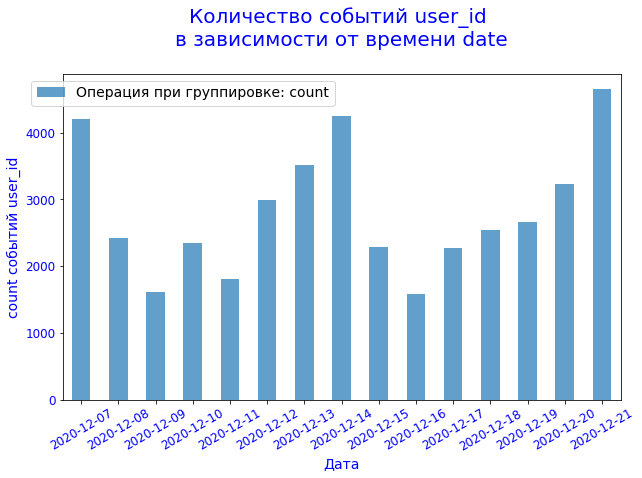

In [308]:
event_in_time_bar(users, 'user_id', 'date', 'count')

Заметно, что при отборе присутствует 7- дневный цикл.  
Полюбопытствуем, как он соотносится с днями недели.

In [309]:
users['weekday'] = pd.to_datetime(users['first_date']).dt.weekday

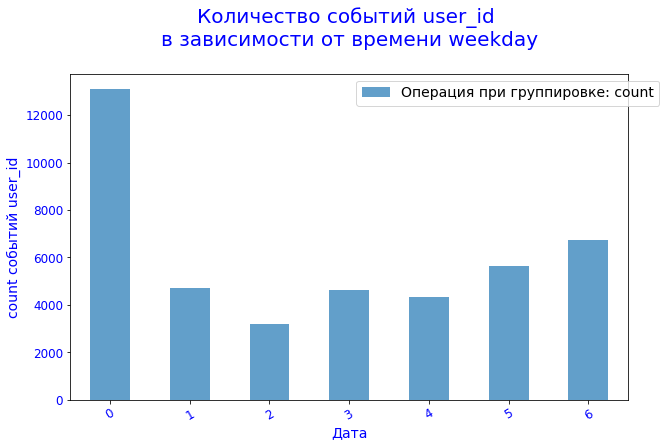

In [310]:
event_in_time_bar(users, 'user_id', 'weekday', 'count')

Как видим, наибольшее число пользователей отбирали для теста по понедельника, а наименьшее - по средам

### Дополним датафрейм `clients_events` столбцом с событиями, переведенными на русский язык

В датафрейме `clients_events` представлены 4 вида событий:
'login'- вход
'product_page' - просмотр карточек товаров
'product_cart' - просмотры корзины
'purchase' - покупки
Дополним датафрейм `clients_events` столбцом с событиями, переведенными на русский язык

In [311]:
def categorize_income(income):
    try:
        if income == "login":
            return '2_вход'
        elif income == "product_page":
            return '3_просмотр_карточек_товаров'
        elif income == 'product_cart':
            return '4_просмотр_корзины'
        elif income == 'purchase':
            return '5_покупки'

    except:
        pass

In [312]:
clients_events['event_name_rus'] = clients_events['event_name'].apply(categorize_income)
clients_events

,user_id,event_dt,event_name,details,event_name_rus
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,1e+02,5_покупки
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,5_покупки
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99,5_покупки
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,5_покупки
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99,5_покупки
...,...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN,2_вход
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN,2_вход
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN,2_вход
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN,2_вход


In [313]:
# проверим на отсутствие пропущенных значений
clients_events.isna().sum()

user_id                0
event_dt               0
event_name             0
details           377577
event_name_rus         0
dtype: int64

### Продуктовая воронка
- активность пользователей: все ли зарегистрированные пользователи прошли авторизацию и совершали переход по продуктовой воронке;
- если есть пользователи, которые не совершали событий после регистрации, изучите их количество и распределение между группами теста; 
- сделайте вывод о необходимости учитывать пользователей без событий при изучении результатов теста;

#### Активность пользователей: все ли зарегистрированные пользователи прошли авторизацию и совершали переход по продуктовой воронке.
##### Подготовка данных 
Данные и список зарегистрированных пользователей содержит датафрейм `users`, а данные о событиях пользователей - датафрейм `clients_events`.  
Чтобы построить продуктовую ворнку, объединим данные этих датафреймов - но используем не все данные - только номер пользователя, дату события и наименование собыитя.   
Но еще нам нужно учесть, что если в датафрейме `users` у нас отражены только пользователи, зарегистрированные в регионе `EU`, то датафрейм `clients_events` содержит сведения о пользователях из всех регионов. Значит, нужно оставить в `clients_events` также только пользователей, зарегистрированных в регионе `EU`   

Создадим, используя данные `users`:
- переменную `user_id_EU`, куда запишем номера пользователей, зарегистрированных в регионе `EU`
- переменную `users_for_funnel` для события `регистрация`, 
- в качестве донора используем датафрейм `clients_events`
- добавим в нее столбец `event_name_rus`   

Объединим датафрейм `clients_events` и переменную `user_id_EU`, чтобы оставить только пользователей, зарегистрированных в регионе `EU`  

Создадим, используя данные `clients_events`:

- переменную `clients_events_for_funnel` для других событий,
- в качестве донора используем датафрейм `clients_events`

Объединим переменные `users_for_funnel` и `clients_events_for_funnel`. Используем метод `concat`. Результат запишем в переменную `purchase_funnel`

In [314]:
# создадим переменную user_id_EU, куда запишем номера пользователей, зарегистрированных в регионе EU
user_id_EU = users['user_id'].reset_index()
user_id_EU

,index,user_id
0,0,D72A72121175D8BE
1,2,2E1BF1D4C37EA01F
2,3,50734A22C0C63768
3,7,8942E64218C9A1ED
4,9,FFCEA1179C253104
...,...,...
42335,61728,1DB53B933257165D
42336,61729,538643EB4527ED03
42337,61730,7ADEE837D5D8CBBD
42338,61731,1C7D23927835213F


In [315]:
# создадим переменную users_for_funnel для события регистрация, добавим в нее столбец event_name_rus
users_for_funnel = users[['user_id', 'first_date']]
users_for_funnel['event_name_rus'] = "1_регистрация"
users_for_funnel = users_for_funnel.rename(columns = {'first_date': 'event_dt'})

users_for_funnel

/tmp/ipykernel_49/2684515173.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,user_id,event_dt,event_name_rus
0,D72A72121175D8BE,2020-12-07,1_регистрация
2,2E1BF1D4C37EA01F,2020-12-07,1_регистрация
3,50734A22C0C63768,2020-12-07,1_регистрация
7,8942E64218C9A1ED,2020-12-07,1_регистрация
9,FFCEA1179C253104,2020-12-07,1_регистрация
...,...,...,...
61728,1DB53B933257165D,2020-12-20,1_регистрация
61729,538643EB4527ED03,2020-12-20,1_регистрация
61730,7ADEE837D5D8CBBD,2020-12-20,1_регистрация
61731,1C7D23927835213F,2020-12-20,1_регистрация


Объединим датафрейм `clients_events` и переменную `user_id_EU`, применив параметр `how = 'inner'`  
То есть те, кто присутствует в `users`, но не присутствует в `clients_events` не войдут в переменную

In [316]:
# Объединим датафрейм clients_events и переменную user_id_EU, 
# чтобы оставить только пользователей, зарегистрированных в регионе EU
clients_events = clients_events.merge(user_id_EU, how = 'inner')
clients_events

,user_id,event_dt,event_name,details,event_name_rus,index
0,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,5_покупки,15
1,7B6452F081F49504,2020-12-09 01:50:37,purchase,4.99,5_покупки,15
2,7B6452F081F49504,2020-12-21 08:04:05,purchase,4.99,5_покупки,15
3,7B6452F081F49504,2020-12-22 15:32:04,purchase,9.99,5_покупки,15
4,7B6452F081F49504,2020-12-07 09:22:55,product_page,NaN,3_просмотр_карточек_товаров,15
...,...,...,...,...,...,...
302648,FE2F3BFF12E5AB13,2020-12-24 09:28:54,login,NaN,2_вход,17535
302649,7836B9BF6BC33911,2020-12-21 19:49:46,login,NaN,2_вход,17538
302650,7836B9BF6BC33911,2020-12-24 06:56:08,login,NaN,2_вход,17538
302651,27767D4BECDD260E,2020-12-26 19:02:18,login,NaN,2_вход,982


Проверим на пропущенные значения: все ОК

In [317]:
clients_events.isna().sum()

user_id                0
event_dt               0
event_name             0
details           257735
event_name_rus         0
index                  0
dtype: int64

<div style="border-radius: 45px;border:solid red 7px; padding: 40px">

Обратим внимание, что если мы объединим по пераметру `how = 'right'` у нас возникнут 2874 пропущенных значения.  
Вот они:

In [318]:
# Объединим датафрейм clients_events и переменную user_id_EU, 
# чтобы оставить только пользователей, зарегистрированных в регионе EU
clients_events_1 = clients_events.merge(user_id_EU, how = 'right')
clients_events_1

,user_id,event_dt,event_name,details,event_name_rus,index
0,D72A72121175D8BE,2020-12-07 21:52:10,product_page,NaN,3_просмотр_карточек_товаров,0
1,D72A72121175D8BE,2020-12-07 21:52:07,login,NaN,2_вход,0
2,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN,4_просмотр_корзины,2
3,2E1BF1D4C37EA01F,2020-12-10 04:13:53,product_cart,NaN,4_просмотр_корзины,2
4,2E1BF1D4C37EA01F,2020-12-12 17:54:57,product_cart,NaN,4_просмотр_корзины,2
...,...,...,...,...,...,...
305522,1C7D23927835213F,2020-12-23 15:47:23,login,NaN,2_вход,61731
305523,1C7D23927835213F,2020-12-25 12:31:04,login,NaN,2_вход,61731
305524,1C7D23927835213F,2020-12-27 03:51:35,login,NaN,2_вход,61731
305525,8F04273BB2860229,2020-12-20 03:17:17,product_cart,NaN,4_просмотр_корзины,61732


In [319]:
clients_events_1.loc[(clients_events_1['event_dt'].isna())]

,user_id,event_dt,event_name,details,event_name_rus,index
46,E6DE857AFBDC6102,NaT,NaN,NaN,NaN,13
339,16C69ED14DA9F4A8,NaT,NaN,NaN,NaN,65
421,2420EA89BB4BB0EA,NaT,NaN,NaN,NaN,80
464,4D851A41ECF4440F,NaT,NaN,NaN,NaN,86
805,8EB0C7622C73BBA3,NaT,NaN,NaN,NaN,145
...,...,...,...,...,...,...
304567,1942FB76074AA16F,NaT,NaN,NaN,NaN,61527
304628,6670B7F8E44E51A9,NaT,NaN,NaN,NaN,61543
304953,FB99C8676FAF89A7,NaT,NaN,NaN,NaN,61610
305249,220B14060698D586,NaT,NaN,NaN,NaN,61674


Отсюда делаем вывод, что в датафрейме `clients_events` присутствуют не все пользователи, которые зарагистрировались в приложении. То есть не все зарагистрировавшиеся пользователи совершали события - логинились, просматривали товары, покупали их.

Создадим переменную `clients_events_for_funnel` для других событий

In [320]:
# создадим переменную clients_events_for_funnel для других событий
clients_events_for_funnel = clients_events[['user_id', 'event_dt', 'event_name_rus']]
clients_events_for_funnel

,user_id,event_dt,event_name_rus
0,7B6452F081F49504,2020-12-07 09:22:53,5_покупки
1,7B6452F081F49504,2020-12-09 01:50:37,5_покупки
2,7B6452F081F49504,2020-12-21 08:04:05,5_покупки
3,7B6452F081F49504,2020-12-22 15:32:04,5_покупки
4,7B6452F081F49504,2020-12-07 09:22:55,3_просмотр_карточек_товаров
...,...,...,...
302648,FE2F3BFF12E5AB13,2020-12-24 09:28:54,2_вход
302649,7836B9BF6BC33911,2020-12-21 19:49:46,2_вход
302650,7836B9BF6BC33911,2020-12-24 06:56:08,2_вход
302651,27767D4BECDD260E,2020-12-26 19:02:18,2_вход


In [321]:
# Объединим переменные `users_for_funnel` и `clients_events_for_funnel`. Результат запишем в переменную `purchase_funnel`
purchase_funnel = pd.concat([users_for_funnel, clients_events_for_funnel], axis=0)
purchase_funnel

,user_id,event_dt,event_name_rus
0,D72A72121175D8BE,2020-12-07 00:00:00,1_регистрация
2,2E1BF1D4C37EA01F,2020-12-07 00:00:00,1_регистрация
3,50734A22C0C63768,2020-12-07 00:00:00,1_регистрация
7,8942E64218C9A1ED,2020-12-07 00:00:00,1_регистрация
9,FFCEA1179C253104,2020-12-07 00:00:00,1_регистрация
...,...,...,...
302648,FE2F3BFF12E5AB13,2020-12-24 09:28:54,2_вход
302649,7836B9BF6BC33911,2020-12-21 19:49:46,2_вход
302650,7836B9BF6BC33911,2020-12-24 06:56:08,2_вход
302651,27767D4BECDD260E,2020-12-26 19:02:18,2_вход


##### Доли событий в логах.
Визуализируем, насколько часто каждое из событий присутствует 

In [322]:
eventname_pie = purchase_funnel.groupby(by='event_name_rus')['event_name_rus'].agg({'count'})
eventname_pie['pie'] = eventname_pie['count']/eventname_pie['count'].sum()
#eventname_pie['pie'] = ('{0:.01%}').format(eventname_pie['count']/eventname_pie['count'].sum())
eventname_pie.sort_values('pie', ascending = False)

,count,pie
event_name_rus,,
2_вход,129495,0.375
3_просмотр_карточек_товаров,85404,0.248
5_покупки,44918,0.13
4_просмотр_корзины,42836,0.124
1_регистрация,42340,0.123


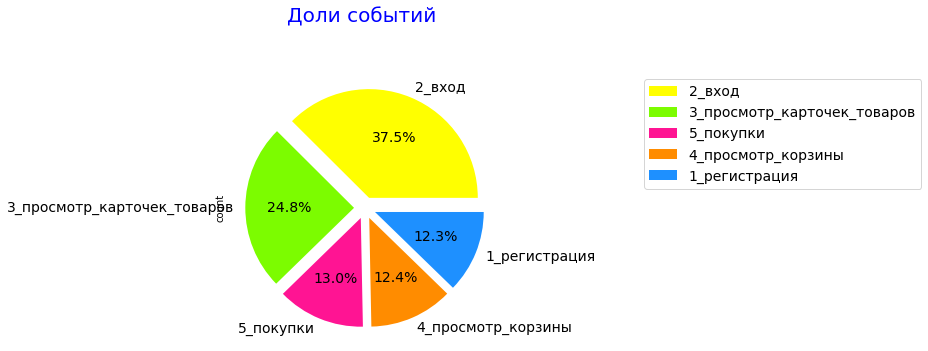

In [323]:
# Построим груговую диаграмму и увидим доли событий в тесте
exp = (0.1,0.1,0.1,0.1,0.1)

eventname_pie.sort_values('pie', ascending = False
                         ).plot(kind='pie', y = 'count', figsize=(5,5)
                         ,colors = ['yellow','LawnGreen','DeepPink','Darkorange','DodgerBlue'],\
                          autopct='%1.1f%%',fontsize=14, explode=exp)
plt.title('Доли событий \n\n', fontsize=20, color = "b")
plt.legend(fontsize=14, bbox_to_anchor=(1.5, 1))
plt.xticks(rotation=0, fontsize=12, color = "b")
plt.yticks(rotation=0, fontsize=12, color = "b")

plt.show()

Видим, что количество регистраций присутствует реже всего - это вполне объяснимо, ведь регистрируется пользователь единожды, а заходить в приложение и совершать покупки может несколько раз.   
И также отметим, что количество событий `Просмотр корзины` меньше, чем количество событий `Покупки` - что говорит о нестрогой воронке и о возможности совершать покупку непосредственно из `Просмотра карточки товара`, минуя этап корзины.

##### Cколько пользователей совершали каждое из этих событий.
Посчитаем, сколько пользователей совершали каждое из событий.  
Посчитаем долю пользователей, которые хоть раз совершали то или тное событие.

In [324]:
# Количество пользователей, которые совершали каждое из событий.
user_name_pie = purchase_funnel.groupby(by='event_name_rus')['user_id'].agg({'nunique'})
# Для расчета доли пользователей, которые хоть раз совершали событие, разделим вычисленное выше количество
# пользователей, которые совершали каждое из событий на общее количесмтво уникальных пользователей в датафрейме data
# Результат представим в процентах и округлим до одного знака после запятой
user_name_pie['pie'] = (user_name_pie['nunique']/purchase_funnel['user_id'].nunique())
pd.options.display.float_format = '{:.1%}'.format
user_name_pie = user_name_pie.sort_values('event_name_rus').reset_index()
user_name_pie

,event_name_rus,nunique,pie
0,1_регистрация,42340,100.0%
1,2_вход,39460,93.2%
2,3_просмотр_карточек_товаров,26105,61.7%
3,4_просмотр_корзины,12964,30.6%
4,5_покупки,13749,32.5%


##### Построим воронку продаж
Для определения воронки событий нам нужно выявить события, последовательное исполнение которых приводит клиента в желаемому нам результату - в данном случае - к оплате отобранного товара. Анализируя представленные в тесте события мы ранее присвоили события номера, соответствующие последовательности действий

In [325]:
fig = go.Figure(go.Funnel(
    y = user_name_pie['event_name_rus'],
    x = user_name_pie['nunique'],
    textposition = "inside",
    textinfo = "value+percent initial + percent previous ",
    opacity = 0.65, marker = {"color": ['DeepPink','Darkorange', 'yellow','LawnGreen','DodgerBlue'],
    "line": {"width": [3, 3, 3, 3], "color": ["wheat", "wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "blue", "dash": "dot", "width": 3}})
                   )
fig.update_layout(
    template = 'simple_white',
    title={
        'text': "Воронка событий",
        'y':0.9,
        'x':0.6,
        'xanchor': 'center',
        'yanchor': 'top',
        #hoverinfo = "text",
        'font': {'size': 20, 'color': 'blue'}
            },
    width = 800,
    height = 700
    )
fig.update_traces(textfont=dict(size=12, color='darkblue'))
fig.show()

Итак, и в столбце `pie` переменной `user_name_pie` и при интерактивном просмотре воронки продаж мы видим, что после регистрации осуществляют вход (логиняться) только 93% пользователей, то есть 7% прекращают использование приложения после регистрации.  
Потери на двух следующих этапах заметно больше, чем на предыдущим: на этап просматра карточки товара переходит 66% от количества залогинившихся, и далее - на этап просмотра корзины и оплаты - 50% от совершивших просмотр каточек товара пользователей.
Результат конечной конверсии равен 10,2% - то есть только десятая часть зарегистрировавшихся пользователей совершили оплату покупки.   
Обращает внимание такая деталь, что количество покупателей на этапе `покупка` несколько больше, чем на этапе `просмотр корзины`. Вероятно, приложение позволяет переходить на этап оплаты товара непосредственно после просмотра катрочки товара, то есть минуя этап корзины

#### Пользователи, которые не совершали событий после регистрации
Изучим пользователей, которые не совершали событий после регистрации, их количество и распределение между группами теста.   

Чуть выше мы выяснили, что 7% (а точнее - 6,8%) пользователей после регистрации не совершали вход в приложение, соответственно, не совершали и иные действия. Таких пользователей 2880 человек.   
Посмотрим, как они распределены между группами теста.    
Для реализации этой цели нам нужно добавить к  переменной `purchase_funnel` данным о  принадлежности пользоватлей к той или иной группе теста. Данные эти, напомним, содержатся в датафрейме `participants`.     
Объединим `purchase_funnel` и `participants`. Для используем тип объединения `outer`, чтобы удостовериться, что в датафрейме `participants` отсутствуют пользователи не из региона `EU`.


In [326]:
len_purchase_funnel = len(purchase_funnel)
len_purchase_funnel

344993

In [327]:
purchase_funnel = purchase_funnel.merge(participants, how = 'outer')
# после объединения оставим только нужные нам столбцы
purchase_funnel = purchase_funnel[['user_id', 'event_dt', 'event_name_rus', 'group']]
purchase_funnel

,user_id,event_dt,event_name_rus,group
0,D72A72121175D8BE,2020-12-07 00:00:00,1_регистрация,A
1,D72A72121175D8BE,2020-12-07 21:52:10,3_просмотр_карточек_товаров,A
2,D72A72121175D8BE,2020-12-07 21:52:07,2_вход,A
3,2E1BF1D4C37EA01F,2020-12-07 00:00:00,1_регистрация,NaN
4,2E1BF1D4C37EA01F,2020-12-07 09:05:47,4_просмотр_корзины,NaN
...,...,...,...,...
344988,1C7D23927835213F,2020-12-25 12:31:04,2_вход,NaN
344989,1C7D23927835213F,2020-12-27 03:51:35,2_вход,NaN
344990,8F04273BB2860229,2020-12-20 00:00:00,1_регистрация,NaN
344991,8F04273BB2860229,2020-12-20 03:17:17,4_просмотр_корзины,NaN


Как видим, после объединения в датафрейме `purchase_funnel` осталось 344993 строк - то есть столько же, как и до объединения. Стало быть, в датафрейме `participants` содержатся данные о пользователях только из региона `EU`

Посмотрим, как для обеих групп теста распределены количество событий , совершенных пользователямию.   
Создадим функцию `users_events`, которая посчитает нам количество и сонверсии пользователей на разных событиях как к регистрации, так и к предыдущему событию. 

In [328]:
def users_events(group_name):
    # Количество пользователей, которые совершали каждое из событий.
    user_name_pie = purchase_funnel.query('group == @group_name').groupby(by='event_name_rus')['user_id'].agg({'nunique'})
    # Для расчета доли пользователей, которые хоть раз совершали событие, разделим вычисленное выше количество
    # пользователей, которые совершали каждое из событий на общее количесмтво уникальных пользователей в датафрейме data
    # Результат представим в процентах и округлим до одного знака после запятой
    user_name_pie['pie'] = (user_name_pie['nunique']/purchase_funnel.query('group == @group_name')['user_id'].nunique())
    
    # Рассчитаем долю пользователей, которые переходят на следующий шаг воронки и созраним результат в столбце conv
    # Результат представим в процентах и округлим до одного знака после запятой
    user_name_pie['conv'] =  (user_name_pie['nunique'] / user_name_pie['nunique'].shift()).fillna('-')
    # Также рассчитаем конверсию каждого шага воронки к первому действию. 
    user_name_pie = user_name_pie.sort_values('event_name_rus').reset_index()
    display(user_name_pie)
    return

In [329]:
users_events("A")

,event_name_rus,nunique,pie,conv
0,1_регистрация,2713,100.0%,-
1,2_вход,1939,71.5%,71.5%
2,3_просмотр_карточек_товаров,1265,46.6%,65.2%
3,4_просмотр_корзины,589,21.7%,46.6%
4,5_покупки,613,22.6%,104.1%


In [330]:
users_events("B")

,event_name_rus,nunique,pie,conv
0,1_регистрация,2036,100.0%,-
1,2_вход,655,32.2%,32.2%
2,3_просмотр_карточек_товаров,367,18.0%,56.0%
3,4_просмотр_корзины,184,9.0%,50.1%
4,5_покупки,191,9.4%,103.8%


Мы отчетливо видим, что конверсия входа к регистрации у пользователей группы "А" значительно (вдвое) выше, чем у  пользователей группы "В".  
При этом для последующих событий конверсия к предыдущему событию в обеих группах сопоставимая.


##### Необходимость учитывать пользователей без событий 
Определимся о необходимости учитывать пользователей без событий при изучении результатов теста.  
Вспомним назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы. Весьма вероятно, что рекомендательная система предполагает под собой рекомендации (товаров) при входе пользователя в приложение. Иначе говоря, пока пользователь не войдет в приложение, он не мождет получить рекомендации, следовательно, мы не можем попосавлять действия пользователей в различных группах.  
Факт того, что в группе "В" более, чем вдвое пользователей реже входят в приложение после регистрации, чем в группе "А" не может быть связан с результатами теста, поскольку на этом этапе события теста еще не начали оказывать влияние на пользователей.  
Следовательно, мы не вправе учитывать пользователей без событий при изучении резулльтатов теста.  
В этой связи:
- исключим из переменной `purchase_funnel` строки, в которых в столбце `event_name_rus` указано событие `1_регистрация`
- исключим из переменной `purchase_funnel` строки, в которых в столбце `group` не укзана принадлежность ни к какой группе
- сохраним изменения в переменной `purchase_funnel_for_test`

In [331]:
purchase_funnel_for_test = purchase_funnel.query('event_name_rus != "1_регистрация"') 
#purchase_funnel_for_test = purchase_funnel_for_test
#purchase_funnel_for_test = purchase_funnel_for_test.dropna(subset=['total_cases', 'deaths', 'case_fatality_rate' ])
purchase_funnel_for_test = purchase_funnel_for_test.dropna()
purchase_funnel_for_test

,user_id,event_dt,event_name_rus,group
1,D72A72121175D8BE,2020-12-07 21:52:10,3_просмотр_карточек_товаров,A
2,D72A72121175D8BE,2020-12-07 21:52:07,2_вход,A
137,831887FE7F2D6CBA,2020-12-07 06:50:29,5_покупки,A
138,831887FE7F2D6CBA,2020-12-09 02:19:17,5_покупки,A
139,831887FE7F2D6CBA,2020-12-07 06:50:30,4_просмотр_корзины,A
...,...,...,...,...
344851,0416B34D35C8C8B8,2020-12-21 22:28:29,3_просмотр_карточек_товаров,A
344852,0416B34D35C8C8B8,2020-12-24 09:12:51,3_просмотр_карточек_товаров,A
344853,0416B34D35C8C8B8,2020-12-20 20:58:25,2_вход,A
344854,0416B34D35C8C8B8,2020-12-21 22:28:29,2_вход,A


In [332]:
purchase_funnel_for_test.isna().sum()

user_id           0
event_dt          0
event_name_rus    0
group             0
dtype: int64

### Горизонт анализа
- рассчитаем лайфтайм совершения события пользователем после регистрации, 
- оставим только те события, которые были совершены в первые 14 дней с момента регистрации;
- проверим, что все участники теста имели возможность совершать события все 14 дней с момента регистрации, 
- оценим, когда пользователи совершают свои первые события каждого вида.

для проведения анализа нам нужно:
- Знать момент и горизонт анализа.
- Рассчитать максимально возможную дату привлечения пользователей.
- Исключить из анализа пользователей, пришедших после этой даты.
- Исключить из результата все лайфтаймы, превышающие горизонт анализа.


В разделе Знакомства с даными мы отметили: "- В датафрейме `clients_events` данные представлены за период с 7 по 30 декабря 2020 года, а по условию исследования должны присутствовать события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года"   
Учитывая, что:
- Дата остановки набора новых пользователей: 2020-12-21;
-  
Обратим внимание, что с **момента регистрации** означает, что день регистрации считается за первый день длярасчета периода в 14 дней.   
Мы ожидали бы наличие данных по как минимум 03 января 2021 года.   
Об зтом же сообщает задание:
- Дата остановки: 2021-01-04

Таким образом, мы должны отметить, что события пользователей, зарегистрированных начиная с нуля часов 18 декабря 2020 года, не "прожили" необходимый по заданию срок в 14 дней (горизонт анализа) и не могут быть учтены при анализе результатов теста .   
Определяем новую Дата остановки: 
- Дата остановки: 2020-12-30




Объединим датафреймы и , чтобы иметь возможность соотнести дату регистрации пользователей и дату события.  
Вычислим лайфтайм для каждого события - помним, что он для анализа не должен превышать размер горизонта анализа - 14 дней 

In [333]:
purchase_funnel_for_test = purchase_funnel_for_test.merge(users[['user_id', 'first_date']])
purchase_funnel_for_test['lifetime'] = (purchase_funnel_for_test['event_dt'] - purchase_funnel_for_test['first_date']).dt.days
purchase_funnel_for_test

,user_id,event_dt,event_name_rus,group,first_date,lifetime
0,D72A72121175D8BE,2020-12-07 21:52:10,3_просмотр_карточек_товаров,A,2020-12-07,0
1,D72A72121175D8BE,2020-12-07 21:52:07,2_вход,A,2020-12-07,0
2,831887FE7F2D6CBA,2020-12-07 06:50:29,5_покупки,A,2020-12-07,0
3,831887FE7F2D6CBA,2020-12-09 02:19:17,5_покупки,A,2020-12-07,2
4,831887FE7F2D6CBA,2020-12-07 06:50:30,4_просмотр_корзины,A,2020-12-07,0
...,...,...,...,...,...,...
17521,0416B34D35C8C8B8,2020-12-21 22:28:29,3_просмотр_карточек_товаров,A,2020-12-20,1
17522,0416B34D35C8C8B8,2020-12-24 09:12:51,3_просмотр_карточек_товаров,A,2020-12-20,4
17523,0416B34D35C8C8B8,2020-12-20 20:58:25,2_вход,A,2020-12-20,0
17524,0416B34D35C8C8B8,2020-12-21 22:28:29,2_вход,A,2020-12-20,1


In [334]:
# задаём момент и горизонт анализа данных
observation_date = datetime(2020, 12, 30).date() 
horizon_days = 14

# создаём опцию «игнорировать горизонт»
ignore_horizon = False

In [335]:
observation_date

datetime.date(2020, 12, 30)

Вычислим максимально возможную дату привлечения пользователей. Она рассчитывается по формуле: `момент анализа данных - горизонт анализа данных`. Вызовем функцию `timedelta()`, чтобы получить временной промежуток, равный максимальному лайфтайму горизонта анализа, и вычтем его из `observation_date`. 

Это и есть максимальная дата привлечения, сохраним её в переменной `last_suitable_acquisition_date`. Теперь можно исключить пользователей, не успевших «прожить» достаточно дней. Сделаем срез профилей методом `query()`: отберём все записи, в которых дата первого посещения из столбца `dt` меньше максимальной.

Также исключим события, для которых лайфтайм превышает горизонт анализа.

In [336]:
purchase_funnel_for_test

,user_id,event_dt,event_name_rus,group,first_date,lifetime
0,D72A72121175D8BE,2020-12-07 21:52:10,3_просмотр_карточек_товаров,A,2020-12-07,0
1,D72A72121175D8BE,2020-12-07 21:52:07,2_вход,A,2020-12-07,0
2,831887FE7F2D6CBA,2020-12-07 06:50:29,5_покупки,A,2020-12-07,0
3,831887FE7F2D6CBA,2020-12-09 02:19:17,5_покупки,A,2020-12-07,2
4,831887FE7F2D6CBA,2020-12-07 06:50:30,4_просмотр_корзины,A,2020-12-07,0
...,...,...,...,...,...,...
17521,0416B34D35C8C8B8,2020-12-21 22:28:29,3_просмотр_карточек_товаров,A,2020-12-20,1
17522,0416B34D35C8C8B8,2020-12-24 09:12:51,3_просмотр_карточек_товаров,A,2020-12-20,4
17523,0416B34D35C8C8B8,2020-12-20 20:58:25,2_вход,A,2020-12-20,0
17524,0416B34D35C8C8B8,2020-12-21 22:28:29,2_вход,A,2020-12-20,1


In [337]:
# рассчитываем максимально возможную дату привлечения
last_suitable_acquisition_date = observation_date
if not ignore_horizon:
    last_suitable_acquisition_date = observation_date - timedelta(
        days=horizon_days - 1
    )

# исключаем пользователей, пришедших после максимальной даты привлечения
purchase_funnel_for_test = purchase_funnel_for_test.query('first_date <= @last_suitable_acquisition_date')


# исключаем события с лайфтаймом более 14 дней
purchase_funnel_for_test = purchase_funnel_for_test.query('lifetime <= @horizon_days')


# для корректности формирования результата приведем столбец event_dt к формату даты и назовем его event_day
purchase_funnel_for_test['event_day'] = pd.to_datetime(purchase_funnel_for_test['event_dt'].dt.date)
# для удобства применения функции переименуем столбец first_date в столбец dt
#df = df.rename(columns={'Track ID': 'track_id', 'Release Year': 'release_year'})
purchase_funnel_for_test = purchase_funnel_for_test.rename(columns = {'first_date':'dt'})

#  pd.to_datetime(profiles['dt']).dt.date
purchase_funnel_for_test

,user_id,event_dt,event_name_rus,group,dt,lifetime,event_day
0,D72A72121175D8BE,2020-12-07 21:52:10,3_просмотр_карточек_товаров,A,2020-12-07,0,2020-12-07
1,D72A72121175D8BE,2020-12-07 21:52:07,2_вход,A,2020-12-07,0,2020-12-07
2,831887FE7F2D6CBA,2020-12-07 06:50:29,5_покупки,A,2020-12-07,0,2020-12-07
3,831887FE7F2D6CBA,2020-12-09 02:19:17,5_покупки,A,2020-12-07,2,2020-12-09
4,831887FE7F2D6CBA,2020-12-07 06:50:30,4_просмотр_корзины,A,2020-12-07,0,2020-12-07
...,...,...,...,...,...,...,...
15972,D19F39FBBBD3B6AD,2020-12-22 05:47:17,2_вход,A,2020-12-13,9,2020-12-22
15973,4CC6ED6ECF5B43F6,2020-12-13 19:51:08,5_покупки,B,2020-12-13,0,2020-12-13
15974,4CC6ED6ECF5B43F6,2020-12-15 13:50:44,5_покупки,B,2020-12-13,2,2020-12-15
15975,4CC6ED6ECF5B43F6,2020-12-13 19:51:08,2_вход,B,2020-12-13,0,2020-12-13


#### Когда пользователи совершают свои первые события каждого вида.
Чтобы оценить, когда пользователи совершают свои первые события каждого вида, воспользуемся имеющимися в нашем распоряжении функциями для вычисления коэффициента удержания и коэффициента конверсии, чуть укоротив их

##### Начало совершения пользователями первых событий
Для получения понимания , когда пользователи начинают совершать события, вычислим и выведем на экран матрицу удержания.  
Используем функцию `get_retention`

In [338]:
def get_retention(
    result_raw, event_name, observation_date, horizon_days, ignore_horizon=False
):



    # рассчитываем удержание
    result_grouped = result_raw.query('event_name_rus == @event_name').pivot_table(
        index=['dt'], columns='lifetime', values='user_id', aggfunc='nunique'
    )
    cohort_sizes = (
        result_raw.groupby('dt')
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on='dt', how='left'
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    # сырые данные пригодятся, если нужно будет отыскать ошибку в расчётах
    return result_raw, result_grouped

Теперь для расчёта коэффициента удержания достаточно вызвать `get_retention()`. Вычислим Retention Rate с учётом нового момента анализа данных — 30 декабря 2020 года. Горизонт анализа по-прежнему составляет 14 дней.


In [339]:
event_list = sorted(purchase_funnel_for_test['event_name_rus'].unique())
for event in event_list:
    retention_raw, retention = get_retention(purchase_funnel_for_test, event, datetime(2020, 12, 30).date(), 14)
    print("\033[34m""\033[1m""Событие:", event)
    display(retention)

Событие: 2_вход


,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,,
2020-12-07,234,92.7%,39.7%,33.8%,22.2%,16.2%,14.5%,12.4%,11.1%,8.1%,9.8%,8.1%,6.0%,5.1%,4.3%
2020-12-08,96,100.0%,58.3%,32.3%,14.6%,10.4%,13.5%,12.5%,14.6%,9.4%,8.3%,12.5%,3.1%,6.2%,3.1%
2020-12-09,110,100.0%,41.8%,20.9%,22.7%,14.5%,13.6%,7.3%,9.1%,8.2%,7.3%,10.9%,6.4%,7.3%,7.3%
2020-12-10,73,100.0%,41.1%,23.3%,6.8%,8.2%,9.6%,15.1%,6.8%,5.5%,6.8%,6.8%,2.7%,6.8%,2.7%
2020-12-11,82,100.0%,42.7%,37.8%,19.5%,13.4%,4.9%,9.8%,9.8%,7.3%,7.3%,3.7%,3.7%,6.1%,6.1%
2020-12-12,82,100.0%,30.5%,24.4%,19.5%,18.3%,11.0%,13.4%,11.0%,6.1%,11.0%,3.7%,3.7%,6.1%,1.2%
2020-12-13,51,100.0%,25.5%,19.6%,11.8%,17.6%,3.9%,7.8%,5.9%,3.9%,3.9%,11.8%,3.9%,5.9%,5.9%
2020-12-14,326,100.0%,52.1%,31.9%,22.7%,17.5%,17.2%,12.0%,12.9%,13.8%,9.8%,6.7%,5.8%,8.3%,8.3%
2020-12-15,167,100.0%,41.9%,35.3%,21.6%,25.1%,19.8%,13.2%,9.6%,10.8%,8.4%,13.2%,4.2%,10.2%,6.0%


Событие: 3_просмотр_карточек_товаров


,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,,
2020-12-07,234,60.7%,26.1%,23.1%,14.5%,11.5%,8.5%,6.4%,7.3%,6.0%,6.4%,5.6%,3.4%,3.0%,2.6%
2020-12-08,96,58.3%,35.4%,17.7%,10.4%,7.3%,7.3%,5.2%,9.4%,6.2%,4.2%,8.3%,1.0%,4.2%,2.1%
2020-12-09,110,60.0%,24.5%,10.0%,11.8%,9.1%,4.5%,4.5%,3.6%,5.5%,4.5%,7.3%,1.8%,5.5%,2.7%
2020-12-10,73,46.6%,13.7%,13.7%,1.4%,2.7%,1.4%,8.2%,4.1%,0.0%,4.1%,4.1%,0.0%,4.1%,0.0%
2020-12-11,82,52.4%,19.5%,19.5%,4.9%,7.3%,3.7%,2.4%,6.1%,6.1%,2.4%,2.4%,1.2%,4.9%,3.7%
2020-12-12,82,59.8%,15.9%,12.2%,7.3%,8.5%,6.1%,7.3%,6.1%,1.2%,3.7%,1.2%,0.0%,3.7%,0.0%
2020-12-13,51,52.9%,9.8%,13.7%,3.9%,7.8%,2.0%,5.9%,2.0%,2.0%,2.0%,3.9%,0.0%,2.0%,3.9%
2020-12-14,326,65.0%,31.9%,20.9%,15.0%,12.6%,11.3%,7.4%,7.4%,8.0%,6.4%,4.3%,4.0%,5.2%,5.2%
2020-12-15,167,63.5%,25.1%,21.0%,12.0%,17.4%,13.2%,9.6%,6.0%,6.0%,6.0%,11.4%,3.0%,7.2%,4.8%


Событие: 4_просмотр_корзины


,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,,
2020-12-07,234,23.9%,9.8%,9.0%,7.7%,5.1%,4.3%,2.6%,2.6%,3.4%,3.8%,2.6%,1.7%,1.3%,1.7%
2020-12-08,96,30.2%,16.7%,9.4%,1.0%,3.1%,5.2%,4.2%,6.2%,1.0%,4.2%,2.1%,0.0%,1.0%,0.0%
2020-12-09,110,27.3%,13.6%,4.5%,7.3%,4.5%,5.5%,1.8%,1.8%,3.6%,1.8%,4.5%,2.7%,2.7%,0.9%
2020-12-10,73,24.7%,8.2%,4.1%,2.7%,1.4%,0.0%,4.1%,2.7%,0.0%,4.1%,0.0%,1.4%,0.0%,1.4%
2020-12-11,82,30.5%,18.3%,9.8%,7.3%,3.7%,2.4%,3.7%,3.7%,1.2%,2.4%,1.2%,0.0%,2.4%,3.7%
2020-12-12,82,18.3%,3.7%,4.9%,2.4%,3.7%,3.7%,2.4%,1.2%,0.0%,2.4%,1.2%,0.0%,2.4%,0.0%
2020-12-13,51,19.6%,5.9%,2.0%,0.0%,0.0%,0.0%,0.0%,5.9%,0.0%,0.0%,2.0%,2.0%,0.0%,0.0%
2020-12-14,326,32.2%,17.2%,11.3%,9.8%,4.6%,4.6%,2.5%,3.4%,4.0%,3.4%,1.5%,1.5%,3.1%,2.8%
2020-12-15,167,39.5%,16.2%,10.2%,8.4%,11.4%,7.2%,4.2%,3.0%,4.2%,4.2%,4.2%,1.8%,3.6%,3.0%


Событие: 5_покупки


,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
dt,,,,,,,,,,,,,,,
2020-12-07,234,31.6%,12.0%,10.7%,5.6%,4.7%,4.7%,5.1%,6.0%,3.4%,2.6%,2.1%,2.1%,2.6%,0.9%
2020-12-08,96,22.9%,14.6%,7.3%,6.2%,2.1%,3.1%,1.0%,1.0%,1.0%,2.1%,0.0%,1.0%,3.1%,1.0%
2020-12-09,110,24.5%,10.9%,4.5%,9.1%,4.5%,0.9%,1.8%,1.8%,1.8%,0.9%,1.8%,3.6%,2.7%,1.8%
2020-12-10,73,30.1%,9.6%,5.5%,1.4%,2.7%,1.4%,4.1%,1.4%,0.0%,1.4%,1.4%,0.0%,0.0%,0.0%
2020-12-11,82,15.9%,4.9%,2.4%,4.9%,1.2%,0.0%,1.2%,0.0%,0.0%,0.0%,1.2%,1.2%,0.0%,1.2%
2020-12-12,82,24.4%,8.5%,7.3%,4.9%,2.4%,1.2%,1.2%,0.0%,0.0%,3.7%,0.0%,0.0%,0.0%,1.2%
2020-12-13,51,15.7%,2.0%,2.0%,2.0%,0.0%,0.0%,0.0%,3.9%,0.0%,0.0%,0.0%,2.0%,0.0%,0.0%
2020-12-14,326,27.6%,12.9%,9.5%,6.7%,4.9%,5.8%,2.8%,3.4%,4.0%,2.8%,2.1%,1.2%,4.0%,2.5%
2020-12-15,167,35.9%,13.2%,12.6%,6.0%,9.0%,4.8%,4.2%,4.2%,2.4%,2.4%,6.6%,1.2%,3.6%,1.8%


Рассматривая результат работы функции `get_retention` мы можем увидеть, что на всем исследуемом промежутке времени:
- пользователи совершают вход в приложение в день регистрации, за исключением одного дня - 7 декабря, когда в день регистрации в приложение вошли только 92,7% пользователей
- в день регистрации карточки товаров просматривают от 46 до 67 % пользователей
- просмотр корзины и покупки в день регистрации совершают от 15 до 40% пользователей 

### Проверим достаточность длительности теста 
Проверим - достаточная ли длительность теста выбрана, чтобы мы могли получить статистически значимый результат. Воспользуемся [калькулятором](https://vwo.com/tools/ab-test-duration-calculator/) и определим минимально необходимую продолжительность теста.  

Пересчитаем процент посетителей, включенных в тест и увидим, что он по-прежнему составляет около  11%

In [340]:
len(participants) /  len(users)

0.11216343882853094

Посчитаем количество посетителей, регистрирующихся в день

In [341]:
round(len(participants) / (((purchase_funnel_for_test['dt']).max() - (purchase_funnel_for_test['dt']).min()).days +1 ))

432

In [342]:
print(
    ' Самая ранняя дата регистрации пользователя - ', pd.to_datetime(purchase_funnel_for_test['dt']).dt.date.min(),'\n',
    'Самая поздняя дата регистрации пользователя - ', pd.to_datetime(purchase_funnel_for_test['dt']).dt.date.max(),'\n',
)

 Самая ранняя дата регистрации пользователя -  2020-12-07 
 Самая поздняя дата регистрации пользователя -  2020-12-17 




Мы проводим простой тест - у нас две группы сравнения, соответственно, 1 вариант сравнения.   
Зададим в калькуляторе значения:
- Текущий коэффициент конверсии - 50%
- Минимальное улучшение коэффициента конверсии, которое вы хотите обнаружить - 5%
- Количество вариантов - 1
- Среднее количество посетителей в день - 432
- Процент посетителей, включенных в тест - 15%

Результат расчета - минимально необходимое количество дней - 15, что не соответствовует изначально запланированной продолжительности теста в 14 дней и тем более не соответствует фактической длительности  теста, составившей 11 дней. 

### Завершая раздел предобработки данных, выделим следующее:
- в наборе данных в датафрейме `participants` (таблица участников тестов) оставили только те записи, которые соответствуют заявленному в исследовании названию теста - `recommender_system_test `
- данные в столбцах с датами привели к формату дата-время (datetime)
- набор данных в датафрейме `users` (пользователи, зарегистрировавшиеся в интернет-магазине) привели к заявленному в исследовании периоду времени 
- удалили из датафрейма`users` (пользователи, зарегистрировавшиеся в интернет-магазине) пользователей, зарегистрированных не в регионе EU.
- удалили из датафрейма `participants` (таблица участников тестов) пользователей, зарегистрированных не в регионе EU 
- выяснили, что:
 - исключено присутствие одних и тех же клиентов одновременно в обеих группах
 - отсутствуют клиенты, не отнесенные ни к какой группе
 - разница в количестве пользователей в группах теста составляет 33,8%.
 - при отборе пользователей в группы теста присутствует 7- дневный цикл.
 - наибольшее число пользователей отбирали для теста по понедельникам, а наименьшее - по средам 
 - после регистрации осуществляют вход (логинятся) только 93% пользователей, то есть 7% прекращают использование приложения после регистрации. Потери на двух следующих этапах заметно больше, чем на предыдущим: на этап просмотра карточки товара переходит 66% от количества залогинившихся, и далее - на этап просмотра корзины и оплаты - 50% от совершивших просмотр каточек товара пользователей. Результат конечной конверсии равен 10,2% - то есть только десятая часть зарегистрировавшихся пользователей совершили оплату покупки.
- Обращает внимание такая деталь, что количество покупателей на этапе покупка несколько больше, чем на этапе просмотр корзины. Вероятно, приложение позволяет переходить на этап оплаты товара непосредственно после просмотра карточки товара, то есть минуя этап корзины 
- выяснили, что конверсия входа к регистрации у пользователей группы "А" значительно (вдвое) выше, чем у пользователей группы "В". При этом для последующих событий конверсия к предыдущему событию в обеих группах примерно одинаковая. 
- исключили из рассмотрения пользователей, которые после регистрации не совершали события 
- исключили пользователей, не успевших «прожить» достаточное (определенное задание) количество дней. 
- исключили события, для которых лайфтайм превышает горизонт анализа.
- выяснили, что пользователи совершают вход в приложение в день регистрации, за исключением одного дня - 7 декабря, когда в день регистрации в приложение вошли только 93,2% пользователей
- в день регистрации карточки товаров просматривают от 48 до 67 % пользователей
- просмотр корзины и покупки в день регистрации совершают от 15 до 38% пользователей
- проверили достаточная ли длительность теста выбрана,  для чего воспользовались калькулятором и определили минимально необходимую продолжительность теста. Результат расчета - минимально необходимое количество дней - 15, что не соответствовует изначально запланированной продолжительности теста в 14 дней и тем более не соответствует фактической длительности  теста, составившей 11 дней. 

 
**Таким образом можно приступить к исследовательскому анализу данных.**

## Исследовательский анализ данных

### Распределение количества событий на пользователя в разрезе групп теста
Построим гистограмму распределения количества событий на пользователя в разрезе групп теста и сравним её средние значения между собой у групп теста.


Для каждого пользователя посчитаем количество событий, сохраним их в переменные `r1000_A` и `r1000_B`

In [343]:
r1000_A = purchase_funnel_for_test.query('group == "A"').groupby(['user_id']).agg({'event_name_rus':'count'})\
    .sort_values('event_name_rus', ascending=False).reset_index()
r1000_B = purchase_funnel_for_test.query('group == "B"').groupby(['user_id']).agg({'event_name_rus':'count'})\
    .sort_values('event_name_rus', ascending=False).reset_index()
display(r1000_A)
r1000_B

,user_id,event_name_rus
0,1BFEE479308EFF44,24
1,6E3DF9C69A6B607E,21
2,8378F834617AA310,20
3,7A197D5142168937,20
4,A25712EE46AD443A,20
...,...,...
1110,3B3AE26404B64EF2,1
1111,26B0521FC2BAB2D1,1
1112,57150D3838DE301A,1
1113,7FF809153882541B,1


,user_id,event_name_rus
0,1198061F6AF34B7B,24
1,115EBC1CA027854A,24
2,89545C7F903DBA34,21
3,FE76759FE6BF8C68,20
4,7E8720DB6A21CF66,20
...,...,...
471,D0D8873714077818,1
472,181181D6E7BA82B4,1
473,7A6E345A0058C71B,1
474,92701F9DF59DC422,1


Зададим функцию `distribution`, которая построит нам гистограмму

In [344]:
def distribution(data_first, data_second, event_name, time_1, time_2):
    ax=data_first.plot(y=event_name, kind='hist', bins=12, figsize=(8, 5), alpha = 0.5 )
    data_second.plot(y=event_name, kind='hist', bins=12, figsize=(8, 5), alpha = 0.4, grid=True, ax=ax)
    #ax2=ax1
    plt.title(f'Распределение по {event_name} \n по критериям {time_1} и {time_2} \n'
             , fontsize=20, color = "b")
    plt.xlabel("Количество событий на пользователя", fontsize = 16, color = "b")
    plt.ylabel("Частота событий", fontsize = 16, color = "b")
    plt.legend(labels=[f"Заказы {time_1}",f"Заказы {time_2}"],fontsize=14, bbox_to_anchor=(0.5, 1))
    plt.xticks(rotation=0, fontsize=12, color = "b")
    plt.yticks(rotation=0, fontsize=12, color = "b")
    #plt.ylim(0,100)
    plt.show()
    
    return

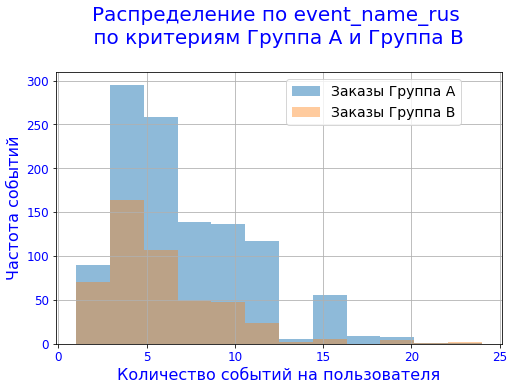

In [345]:
distribution(r1000_A, r1000_B, "event_name_rus", "Группа А", "Группа В")

Мы видим, что наиболее часто в обеих группах пользователи совершают от 4 до 7 событий.  
Для пользователей из группы А наблюдается всплеск событий для 15-16 заказов  
В обеих группах визуализируются единичные сделки для более, чем 16 заказов, а при укрупнении графика - и для более, чем 20 заказов

### Посчитаем среднее число событий на пользователя. 

In [346]:
def avg_events_per_costomer(data_name, group):
    print(f"\033[34m"f'Cреднее число событий на пользователя в группе {group}: '"\033[01m"
          , round((data_name['event_name_rus'].mean()),1))
    return      

In [347]:
avg_events_per_costomer(r1000_A, 'A')

Cреднее число событий на пользователя в группе A:  7.0


In [348]:
avg_events_per_costomer(r1000_B, 'B')

Cреднее число событий на пользователя в группе B:  5.7


#### Не ограничимся арифметикой и посчитаем статистическую значимость различий методом Манна-Уитни
Посчитаем статистическую значимость различий между группами. 
Сделаем выводы и предположения.

Для расчета используем небольшую функцию test_mannwhitneyu.

In [349]:
def test_mannwhitneyu (sample_1, sample_2):
    # уровень статистической значимости. Если p-value окажется меньше него, отвергнем гипотезу
    alpha = 0.05 
    # применим метод Манна-Уитни
    results = st.mannwhitneyu(sample_1, sample_2)

    print('p-значение:', "{0:.3f}".format(results[1]))

    if results.pvalue < alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Нет оснований отвергнуть нулевую гипотезу')
    return 

Сформулируем нулевую гипотезу:  
Отсутствуют статистически значимые различия в Количество событий на пользователя в группе А и группе В.

Запустим тест Манна-Уитни

In [350]:
test_mannwhitneyu(r1000_A['event_name_rus'], r1000_B['event_name_rus'])

p-значение: 0.000
Отвергаем нулевую гипотезу


Значение p-value = 0.000 и оно меньше 0.05.<br>
Таким образом, мы должны сделать вывод, что у нас нет оснований принять нулевую гипотезу о том, что нет статистически значимых различий в Количество событий на пользователя в группе А и группе В.

Ранее мы могли видеть, что у некоторых пользователей только одно событие.  
Логично предположить, что это событие - `вход` в приложение, `login`.  
Интересно посмотреть на среднее количество собитий пользователей, которые не только совершили вход в приложение, но и совершили в нем иные действия - просмотр товаров, просмотр корзины, покупки.  
Фразу в задании: "Проверьте, все ли пользователи совершали события. Посчитайте среднее число событий на пользователя для всех пользователей и только для тех, которые совершали события." - трактуем так, что `вход` не считается за событие.  
Исключим событие `вход` и еще раз посчитаем среднее число событий на пользователя.

Создадим для реализации задачи переменные `r1000_A_exc_login` и `r1000_B_exc_login`

In [351]:
r1000_A_exc_login = purchase_funnel_for_test.query('group == "A" and event_name_rus != "2_вход"').groupby(['user_id']).agg({'event_name_rus':'count'})\
    .sort_values('event_name_rus', ascending=False).reset_index()
r1000_B_exc_login = purchase_funnel_for_test.query('group == "B" and event_name_rus != "2_вход"').groupby(['user_id']).agg({'event_name_rus':'count'})\
    .sort_values('event_name_rus', ascending=False).reset_index()
display(r1000_A_exc_login)
r1000_B_exc_login

,user_id,event_name_rus
0,1BFEE479308EFF44,18
1,7A197D5142168937,15
2,4B159898DE46AC3A,15
3,C24D35CD1D858C2C,15
4,F8317163930006BE,15
...,...,...
908,DC04698A6F7BD3C7,1
909,0DB549C6C1DE1AB5,1
910,9709EF8B153900FF,1
911,511A2D5B22AD641A,1


,user_id,event_name_rus
0,1198061F6AF34B7B,18
1,115EBC1CA027854A,16
2,7E8720DB6A21CF66,15
3,4EFB5E89AC11AC6D,15
4,2C2BE85372033F77,15
...,...,...
360,38188B7456DEB035,1
361,1BA8A54DBDAE0EF4,1
362,783BF6971403696B,1
363,3F8981C8DA6F2E21,1


Вновь воспользуемся функцией `avg_events_per_costomer`

In [352]:
avg_events_per_costomer(r1000_A_exc_login, 'A')

Cреднее число событий на пользователя в группе A:  4.8


In [353]:
avg_events_per_costomer(r1000_B_exc_login, 'B')

Cреднее число событий на пользователя в группе B:  3.8


Можем сделать вывод, что как для всех пользователей, так и для пользователей, совершивших события, среднее количество событий в группе "А" превышает среднее количество событий в группе "В".

#### Вновь посчитаем статистическую значимость различий методом Манна-Уитни
Посчитаем статистическую значимость различий между группами. 

Сформулируем нулевую гипотезу:  
Отсутствуют статистически значимые различия в Количество событий на пользователя в группе А и группе В при исключении события `вход`.

Запустим тест Манна-Уитни

In [354]:
test_mannwhitneyu(r1000_A_exc_login['event_name_rus'], r1000_B_exc_login['event_name_rus'])

p-значение: 0.000
Отвергаем нулевую гипотезу


Значение p-value = 0.000 и оно меньше 0.05.<br>
Таким образом, мы должны сделать вывод, что у нас нет оснований принять нулевую гипотезу о том, что нет статистически значимых различий в Количество событий на пользователя в группе А и группе В при исключении события `вход`.

### Динамика количества событий в группах теста по дням
Изучим распределение числа событий по дням
Сравним динамику групп теста между собой.


#### Распределение числа событий по дням
Для каждого дня:
- посчитаем, сколько в этот день событий совершили пользователи из группы А и Б
- посчитаем, сколько пользователей из группы А и Б в этот день совершали события
- рассчитаем количество событий на покупателя за каждый день
- построим и проанализируем график

Создадим переменную `events_per_user`, в которой произведем три первых из вышеуказанных действий

In [355]:
pd.options.display.float_format = '{:.3}'.format

In [356]:
def events_per_user(group_name):
    events_per_user_group = purchase_funnel_for_test.loc[(purchase_funnel_for_test['group'] == group_name)]\
        .groupby('event_day').agg({'event_name_rus':'count', 'user_id':'nunique'})
    events_per_user_group['avg'] = events_per_user_group['event_name_rus'] / events_per_user_group['user_id']
    return (events_per_user_group)

Вызовем функцию `events_per_user` и запишем в переменные `events_per_user_A` и `events_per_user_B` получившиеся таблицы

In [357]:
events_per_user_A = events_per_user('A')
events_per_user_B = events_per_user('B')
events_per_user_B

,event_name_rus,user_id,avg
event_day,,,
2020-12-07,268,119,2.25
2020-12-08,169,82,2.06
2020-12-09,250,117,2.14
2020-12-10,182,89,2.04
2020-12-11,115,59,1.95
2020-12-12,150,75,2.0
2020-12-13,103,54,1.91
2020-12-14,193,95,2.03
2020-12-15,164,82,2.0


In [358]:
events_per_user = purchase_funnel_for_test\
        .groupby(['event_day', 'group']).agg({'event_name_rus':'count', 'user_id':'nunique'}).reset_index()
events_per_user['avg'] = events_per_user['event_name_rus'] / events_per_user['user_id']
events_per_user['event_day'] = pd.to_datetime(events_per_user['event_day']).dt.date
events_per_user = events_per_user.reset_index()
events_per_user

,index,event_day,group,event_name_rus,user_id,avg
0,0,2020-12-07,A,221,103,2.15
1,1,2020-12-07,B,268,119,2.25
2,2,2020-12-08,A,239,108,2.21
3,3,2020-12-08,B,169,82,2.06
4,4,2020-12-09,A,282,128,2.2
5,5,2020-12-09,B,250,117,2.14
6,6,2020-12-10,A,246,113,2.18
7,7,2020-12-10,B,182,89,2.04
8,8,2020-12-11,A,264,128,2.06
9,9,2020-12-11,B,115,59,1.95


In [359]:
events_per_user['event_day'] = pd.to_datetime(events_per_user['event_day']).dt.date


Построим график распределения числа событий на покупателя за каждый день

In [360]:
# строим столбчатую диаграмму, отражающую количество событий в зависимости от времени
def event_in_event_day(data_name, column, group1, group2, eventname, operation, time_interval):
    t1 = data_name.loc[(data_name[column] == group1)].groupby(time_interval).agg({eventname:operation})
    t2 = data_name.loc[(data_name[column] == group2)].groupby(time_interval).agg({eventname:operation})
    
    ax = t1.plot(figsize=(10,6),
    kind ='bar',
    y = eventname,
    linewidth=5,
    alpha=0.5, 
    label='События в группе: '+ group1,
    #ax=ax
    )
    t2.plot(figsize=(10,6),
    kind ='bar',
    y = eventname,
    linewidth=5,
    alpha=0.7, 
    label='События в группе: '+ group2,
    ax=ax,
            color = 'y'
    )
    #plt.title('Количество событий {} \nв зависимости от времени {}\n'.format(eventname, time_interval), fontsize=20, color = "b")
    plt.legend(fontsize=14, bbox_to_anchor=(0.5, 1))
    plt.xticks(rotation=90, fontsize=12, color = "b")
    plt.yticks(rotation=0, fontsize=12, color = "b")
    plt.xlabel('Дата', fontsize=14, color = "b")
    plt.ylabel(f"{operation} событий {eventname}", fontsize=14, color = "b")
    
    return

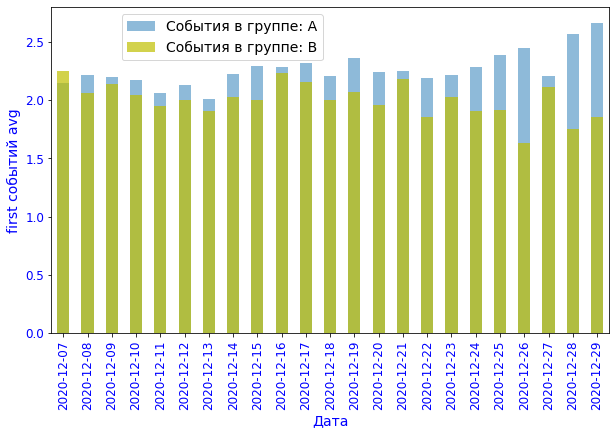

In [361]:
event_in_event_day(events_per_user, 'group', 'A', 'B', 'avg', 'first', 'event_day')

Анализируя график можно увидеть, что значения количества событий в расчете на покупателя по дням изменяются с одинаковой закономерностью.  
Но количество событий в расчете на покупателя в группе А выше, чем в группе В.  
При построении графика абсолютного количества событий (ниже) можно отметить всплеск событий 14 декабря и их рост в течение 4-х дней.  
После чего наступил плавный откат до конца тестируемого периода.  
Возможно предположить, что всплеск связан с проведением маркетинговой оативности (мы отмечали при знакомстве с данными, что маркетинговые мероприятия длятся обычно (но не всегда) от 3 до 6 дней). Заглянем в файл `marketing_events`

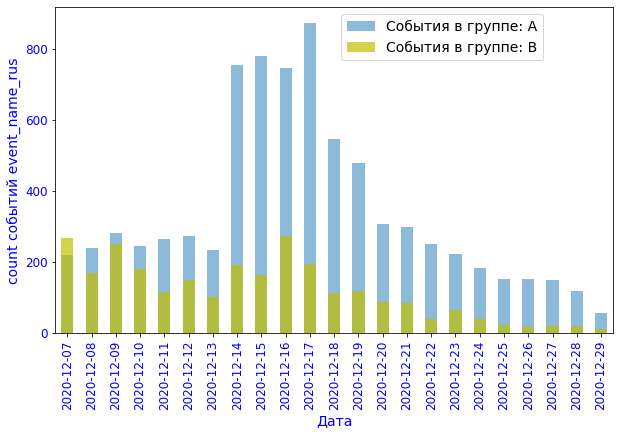

In [362]:
purchase_funnel_for_test['event_day'] = (purchase_funnel_for_test['event_day']).dt.date
event_in_event_day(purchase_funnel_for_test, 'group', 'A', 'B', 'event_name_rus','count', 'event_day' )



In [363]:
marketing_events.sort_values('start_dt')

,name,regions,start_dt,finish_dt,duration
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07,13 days
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,2 days
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,2 days
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,2 days
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,7 days
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,2 days
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11,2 days
11,Dragon Boat Festival Giveaway,APAC,2020-06-25,2020-07-01,6 days
4,4th of July Promo,N.America,2020-07-04,2020-07-11,7 days
13,Chinese Moon Festival,APAC,2020-10-01,2020-10-07,6 days


Нет, в период с 13 по 17 декабря маркетинговые меропиятия на регион `EU`. 
Следовательно, рост количества событий может быть связан как раз с тестированием изменений, связанных с внедрением
улучшенной рекомендательной системы.

#### Сравнительная динамика групп теста 

- распределение событий между группами по датам регистрации пользователей.

Создадим переменную `events_per_user_fist_day`, в которой произведем расчет количества событий по дням регистрации

In [364]:
events_per_user_fist_day = purchase_funnel_for_test\
        .groupby(['dt', 'group']).agg({'event_name_rus':'count', 'user_id':'nunique'}).reset_index()
events_per_user_fist_day['avg'] = events_per_user_fist_day['event_name_rus'] / events_per_user_fist_day['user_id']
events_per_user_fist_day['dt'] = (events_per_user_fist_day['dt']).dt.date
events_per_user_fist_day = events_per_user_fist_day.reset_index()
events_per_user_fist_day

,index,dt,group,event_name_rus,user_id,avg
0,0,2020-12-07,A,688,109,6.31
1,1,2020-12-07,B,846,125,6.77
2,2,2020-12-08,A,451,65,6.94
3,3,2020-12-08,B,160,31,5.16
4,4,2020-12-09,A,362,56,6.46
5,5,2020-12-09,B,305,54,5.65
6,6,2020-12-10,A,225,45,5.0
7,7,2020-12-10,B,119,28,4.25
8,8,2020-12-11,A,397,69,5.75
9,9,2020-12-11,B,43,13,3.31


Построим график распределения числа событий на покупателя по дням регистрации покупателей

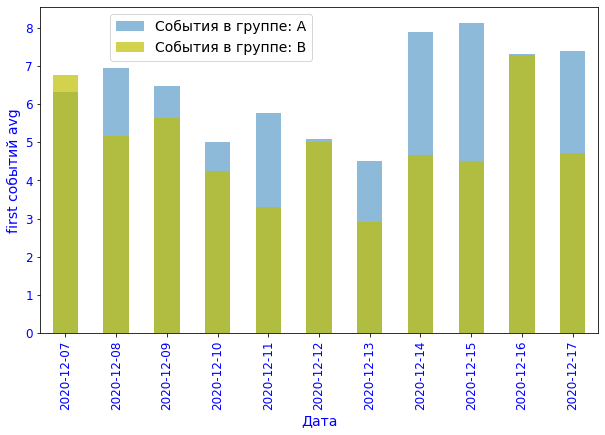

In [365]:
event_in_event_day(events_per_user_fist_day, 'group', 'A', 'B', 'avg', 'first', 'dt')

Аналогично предыдущему графику количество событий в расчете на покупателя в большинстве случаев в группе А выше, чем в группе В.  
Но всплеск событий 14 декабря и их рост в течение 4-х дней характере в более значительной мере для пользователей в группе А.


### Пересечение времени проведения теста с маркетинговыми и другими активностями
- Проверим, совпадает ли время проведения теста с маркетинговыми и другими активностями. 
- Настроим автоматическую проверку, выдающую список событий, пересекающихся с тестом. 
- При необходимости оценим воздействие маркетинговых событий на динамику количества событий.

Набор пользователей (скорректированный по моменту анализа) производилмя с 7 по 17 декабря.
Последняя дата предоставленных нам данных о событиях - 30 декабря.
В период с 7 по 30 декабря на регион `EU` транслировалась только одно маркетинговое сероприятие - это `Christmas&New Year Promo`, которое проводилось в диапазоне с 2020-12-25 по 2021-01-03.  
По исследованным чуть ранее данным мы не видим влияние на тестируемых пользователей этого маркетингового мроприятия.


Для настройки автоматической проверки, выдающей список событий, пересекающихся с тестом, воспользуемся методом `merge()`  и объединим датафреймы `marketing_events` и `purchase_funnel_for_test`. В качестве столбца для объединения примем даты событий, а параметру `how` придадим значение `inner`.   
Если в результате объединения мы получим пустую таблицу - это будет означать, что у объединяемых датафреймов не нашлось общих дат - дат, имеющихся в обоих датафреймах.  
Если же общие даты присутствуют в обоих датафреймах, то мы получим в новой таблице некие значения. 
Поскольку в датафрейме `marketing_events` присутствуют две даты - даты начала и окончания мероприятия - объединять будем в две переменные.

Перед объединением нам следует использовать в датафрейме `marketing_events` мероприятия, относящиеся только к интересующему нас региону - в даннном случае - региону `EU`.
Используем метод str.find(). В датафрейме `marketing_events` создадим столбец `indexes`, в котором отразится значение `-1` в случае, если искомый символ - `EU` -не будет присутствовать в строке.

In [366]:
# substring to be searched
sub ='EU'
# creating and passing series to new column
marketing_events["indexes"]= marketing_events["regions"].str.find(sub)

marketing_events = marketing_events.query('indexes != -1')
marketing_events

,name,regions,start_dt,finish_dt,duration,indexes
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,9 days,0
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16,2 days,0
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19,2 days,0
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19,7 days,0
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01,5 days,0
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03,2 days,0
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10,2 days,0


Объединим датафреймы `marketing_events` и `purchase_funnel_for_test`.

In [367]:
purchase_funnel_for_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10543 entries, 0 to 15976
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         10543 non-null  object        
 1   event_dt        10543 non-null  datetime64[ns]
 2   event_name_rus  10543 non-null  object        
 3   group           10543 non-null  object        
 4   dt              10543 non-null  datetime64[ns]
 5   lifetime        10543 non-null  int64         
 6   event_day       10543 non-null  object        
dtypes: datetime64[ns](2), int64(1), object(4)
memory usage: 658.9+ KB


In [368]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7 entries, 0 to 8
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   name       7 non-null      object         
 1   regions    7 non-null      object         
 2   start_dt   7 non-null      datetime64[ns] 
 3   finish_dt  7 non-null      datetime64[ns] 
 4   duration   7 non-null      timedelta64[ns]
 5   indexes    7 non-null      int64          
dtypes: datetime64[ns](2), int64(1), object(2), timedelta64[ns](1)
memory usage: 392.0+ bytes


In [369]:
purchase_funnel_for_test['event_dt'] = (purchase_funnel_for_test['event_dt']).dt.date
marketing_events['start_dt'] = (marketing_events['start_dt']).dt.date
marketing_events['finish_dt'] = (marketing_events['finish_dt']).dt.date

In [370]:
u1000 = purchase_funnel_for_test.merge(marketing_events, left_on = 'event_day', right_on = 'start_dt', how = 'inner')
u2000 = purchase_funnel_for_test.merge(marketing_events, left_on = 'event_day', right_on = 'finish_dt', how = 'inner')
display(u1000.head())
u2000.head()

,user_id,event_dt,event_name_rus,group,dt,lifetime,event_day,name,regions,start_dt,finish_dt,duration,indexes
0,FEE93E9CF4315356,2020-12-25,2_вход,A,2020-12-14,11,2020-12-25,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,9 days,0
1,39393B197D7743EB,2020-12-25,4_просмотр_корзины,A,2020-12-14,11,2020-12-25,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,9 days,0
2,39393B197D7743EB,2020-12-25,3_просмотр_карточек_товаров,A,2020-12-14,11,2020-12-25,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,9 days,0
3,39393B197D7743EB,2020-12-25,2_вход,A,2020-12-14,11,2020-12-25,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,9 days,0
4,B5DC591BA6B42056,2020-12-25,2_вход,B,2020-12-14,11,2020-12-25,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03,9 days,0


,user_id,event_dt,event_name_rus,group,dt,lifetime,event_day,name,regions,start_dt,finish_dt,duration,indexes


In [371]:
if u1000.shape[0] == 0:
    if u2000.shape[0] == 0:
        print("\033[34m""\033[01m""Пересечение отсутствует")
else:
    print("\033[34m""\033[01m""События и мероприятия пересекаются!")
   

События и мероприятия пересекаются!


Как мы видим, события в период проведения теста пересекаются с маркетинговыми мероприятиями.

### Продуктовая воронка
- построим простые продуктовые воронки для двух групп теста с учетом логической последовательности совершения событий; 
- изучим изменение конверсии в продуктовой воронке тестовой группы, по сравнению с контрольной: наблюдается ли ожидаемый эффект увеличения конверсии в группе В, относительно конверсии в группе А?

In [372]:
purchase_funnel_for_test = purchase_funnel_for_test.reset_index(drop=True)
purchase_funnel_for_test

,user_id,event_dt,event_name_rus,group,dt,lifetime,event_day
0,D72A72121175D8BE,2020-12-07,3_просмотр_карточек_товаров,A,2020-12-07,0,2020-12-07
1,D72A72121175D8BE,2020-12-07,2_вход,A,2020-12-07,0,2020-12-07
2,831887FE7F2D6CBA,2020-12-07,5_покупки,A,2020-12-07,0,2020-12-07
3,831887FE7F2D6CBA,2020-12-09,5_покупки,A,2020-12-07,2,2020-12-09
4,831887FE7F2D6CBA,2020-12-07,4_просмотр_корзины,A,2020-12-07,0,2020-12-07
...,...,...,...,...,...,...,...
10538,D19F39FBBBD3B6AD,2020-12-22,2_вход,A,2020-12-13,9,2020-12-22
10539,4CC6ED6ECF5B43F6,2020-12-13,5_покупки,B,2020-12-13,0,2020-12-13
10540,4CC6ED6ECF5B43F6,2020-12-15,5_покупки,B,2020-12-13,2,2020-12-15
10541,4CC6ED6ECF5B43F6,2020-12-13,2_вход,B,2020-12-13,0,2020-12-13


#### Cколько пользователей совершали каждое из  событий.
Посчитаем, сколько пользователей совершали каждое из событий.  
Посчитаем долю пользователей, которые хоть раз совершали то или иное событие.

In [373]:
# Количество пользователей, которые совершали каждое из событий.
users_for_funnel = purchase_funnel_for_test.groupby(by=['event_name_rus', 'group'])['user_id'].agg({'nunique'})

users_for_funnel = users_for_funnel.sort_values('event_name_rus').reset_index()
users_for_funnel

,event_name_rus,group,nunique
0,2_вход,A,1115
1,2_вход,B,475
2,3_просмотр_карточек_товаров,A,723
3,3_просмотр_карточек_товаров,B,265
4,4_просмотр_корзины,A,350
5,4_просмотр_корзины,B,139
6,5_покупки,A,333
7,5_покупки,B,132


#### Построим продуктовую воронку продаж
Для определения воронки событий нам нужно выявить события, последовательное исполнение которых приводит клиента в желаемому нам результату - в данном случае - к оплате отобранного товара. 

In [374]:
def funnel_per_groups(group_name):
    fig = go.Figure(go.Funnel(
    y = users_for_funnel.query('group == @group_name')['event_name_rus'],
    x = users_for_funnel.query('group == @group_name')['nunique'],
    textposition = "inside",
    textinfo = "value+percent initial + percent previous ",
    opacity = 0.65, marker = 
    {"color": ['DeepPink','Darkorange', 'yellow','LawnGreen'],                    
    "line": {"width": [3, 3, 3, 3], "color": ["wheat", "wheat", "wheat", "wheat", "wheat"]}},
    connector = {"line": {"color": "blue", "dash": "dot", "width": 3}})
                   )
    fig.update_layout(
    template = 'simple_white',
    title={
        'text': f"Воронка событий группа {group_name}",
        'y':0.9,
        'x':0.6,
        'xanchor': 'center',
        'yanchor': 'top',
        #hoverinfo = "text",
        'font': {'size': 20, 'color': 'blue'}
            },
    width = 600,
    height = 450
    )
    fig.update_traces(textfont=dict(size=12, color='darkblue'))
    fig.show()
    
    return

In [375]:
funnel_per_groups("A")

In [376]:
funnel_per_groups("B")

изучите изменение конверсии в продуктовой воронке тестовой
группы, по сравнению с контрольной: наблюдается ли ожидаемый эффект
увеличения конверсии в группе В, относительно конверсии в группе А?
- конверсия в просмотр катрочек в тестовой группе меньше, чем в контрольной.
- конверсия в просмотр корзины от:
 - просмотра карточек в тестовой группе больше на 4%, чем в контрольной
 - входа в тестовой группе меньше на 2%, чем в контрольной 
- конверсия в покупки от:
 - просмотра корзины в тестовой группе и в контрольной группе равны
 - входа в тестовой группе меньше на 1%, чем в контрольной  
 

**Проведем статистический тест и выясним, является ли такое отличие между группами статистически значимым для всех событий.**

### Вывод по разделу Исследовательский анализ данных
- фразу в задании: "Проверьте, все ли пользователи совершали события. Посчитайте среднее число событий на пользователя для всех пользователей и только для тех, которые совершали события." - трактуем так, что вход не считается за событие. По этой причине исключили событие вход и еще раз посчитали среднее число событий на пользователя. 
 - вывод, что как для всех пользователей, так и для пользователей, совершивших события, среднее количество событий в группе "А" превышает среднее количество событий в группе "В".
- значения количества событий по дням изменяются с одинаковой закономерностью для обеих групп.
- отметили всплеск событий 14 декабря и их рост в течение 4-х дней, который не связан с проведением маркетинговой активности. Поскольку всплеск характерен для пользователей обеих групп, рост количества событий не может быть связан с тестированием изменений, связанных с внедрением улучшенной рекомендательной системы.
- проведение маркетинговых мероприятий с 25 декабря не отразились на событиях.
- отличий в конверсии между контрольной и тестовой группами не наблюдается


## Выявим наличие статистической разницы между группами для А/В теста

- Проведем оценку результатов A/B-тестирования: 
 - проверим статистическую разницу долей z-критерием.
 - проверим, был ли достигнут ожидаемый эффект в изменении конверсии

Проверим, находят ли статистические критерии разницу между выборками А и В.   
**Проверим гипотезу о равенстве долей**  

### Сформулируем гипотезу
Сформулируем нулевую гипотезу: между посетителями контрольной и тестовой групп (групп А и В) отсутствует статистически значимая разница доли (конверсии) посетителей из входа (в приложение) в покупку.  
Сформулируем и альтернативную гипотезу: между посетителями контрольной и тестовой групп (групп А и В) существует статистически значимая разница доли (конверсии) посетителей из входа (в приложение) в покупку.  

### Подготовим инструменты
Создадим фунуцию ```prepare_test```, которая будет рассчитывать количество уникальных посетителей для произвольной страницы приложения.   
Создадим фунуцию ```z_test```, для расчета статистического теста.

Нам предстоит провести несколько сравнений, проводимых на одних и тех же данных — это множественный тест. Его важная особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. Чтобы снизить вероятность ложнопозитивного результата при множественном тестировании гипотез, применяют разные методы корректировки уровня статистической значимости. Наиболее распостраненным, но при этом и наиболее грубым является Метод Бонферрони (поправка Бонферрони).   

В ходе исследования мы обнаружили 3 ступени воронки. Напомним, что ранее мы исключили из вопронки этап регистрации пользователя. Таким образом, нам предстоит произвести 3 проверки гипотез, 3 сравнения.  
Учитывая сказанное примем размер поправки Бонферонни равным 3.

In [377]:
def prepare_test (group_name, event, data_name):
    # общее количество посетителей приложения (совершивших вход в приложение) в заданной группе за период теста
    visitors_trials = data_name.query('group == @group_name').agg({'user_id':'nunique'})
    print ('Общее количество посетителей приложения в группе {}:         '.format(group_name), visitors_trials[0])
       
    # Количество посетителей сайта в заданной группе за период теста
    visitors_successes = data_name\
            .query('group == @group_name and event_name_rus == @event').agg({'user_id':'nunique'})
    print ('Количество посетителей страницы {} в группе {}: \t'.format(event, group_name), visitors_successes[0])        
    return visitors_trials, visitors_successes

In [378]:
def z_test (group1, group2, event, data_name, bonferonni = 3):
    #Сравним доли клиентов, сделавших заказ. 
    # зададим критический уровень статистической значимости
    alpha = 0.05 
    # применим поправку Бонферонни
    alpha_bonferonni = alpha / bonferonni
    # статистика успехов
    successes = np.array([prepare_test(group1, event, data_name)[1], prepare_test(group2, event, data_name)[1]])
    # статистика просмотров
    trials = np.array([prepare_test(group1, event, data_name)[0], prepare_test(group2, event, data_name)[0]])
    
    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    
    print (successes[0], successes[1],trials[0], trials[1])
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2
    
#Посчитаем статистику в стандартных отклонениях стандартного нормального распределения: 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 
    
# Если бы пропорции были равны, разница между ними была бы равна нулю. Посчитаем, как далеко статистика уехала от нуля. 
# Какова вероятность получить такое отличие или больше? Применим метод cdf(). 
# Саму статистику возьмём по модулю методом abs() — чтобы получить правильный результат независимо от её знака. 
# Это возможно, потому что тест двусторонний. По этой же причине удваиваем результат:

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', round(p_value[0],3), 'alpha_bonferonni', round(alpha_bonferonni,3))

    if p_value < alpha_bonferonni:
        print("\033[31m {}" .format('Отвергаем нулевую гипотезу: между долями есть значимая разница'))
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
             
    return    

### Конверсия перехода на события
Мы считаем конверсию в каждый шаг от начального шага воронки.   
Вычислим в обеих группах:
- общее количество посетителей приложения (совершивших вход в приложение)  
- и количество посетителей, совершивших событие:
 - `3_просмотр_карточек_товаров`
 - `4_просмотр_корзины`
 - `5_покупки`

Проведем статистический тест, сравним доли клиентов, совершивших указанные события и проверим гипотезу.\
Вызовем функцию `z_test`.\
Перед этим передадим переменной `event_list_z_test` список событий зха исключением входа в приложение

In [379]:
event_list_z_test = \
        purchase_funnel_for_test.loc[(purchase_funnel_for_test['event_name_rus'] != '2_вход')]['event_name_rus'].unique()
event_list_z_test = sorted(event_list_z_test)
event_list_z_test

['3_просмотр_карточек_товаров', '4_просмотр_корзины', '5_покупки']

In [380]:
for event in event_list_z_test:
    print()
    print("\033[31m""\033[1m""Событие:", event, "\033[34m {}")
    z_test('A', 'B', event, purchase_funnel_for_test)



Событие: 3_просмотр_карточек_товаров  {}
Общее количество посетителей приложения в группе A:          1115
Количество посетителей страницы 3_просмотр_карточек_товаров в группе A: 	 723
Общее количество посетителей приложения в группе B:          476
Количество посетителей страницы 3_просмотр_карточек_товаров в группе B: 	 265
Общее количество посетителей приложения в группе A:          1115
Количество посетителей страницы 3_просмотр_карточек_товаров в группе A: 	 723
Общее количество посетителей приложения в группе B:          476
Количество посетителей страницы 3_просмотр_карточек_товаров в группе B: 	 265
[723] [265] [1115] [476]
p-значение:  0.001 alpha_bonferonni 0.017
 Отвергаем нулевую гипотезу: между долями есть значимая разница

Событие: 4_просмотр_корзины  {}
Общее количество посетителей приложения в группе A:          1115
Количество посетителей страницы 4_просмотр_корзины в группе A: 	 350
Общее количество посетителей приложения в группе B:          476
Количество посетител

### Проверим наличие статистически значимой разница для различного вида устройств.
Возможно, на каком-либо из устройств тестируемые изменения покажут результат?  
Но какой же размер поправки Бонферотти нам следует принять? Ведь у нас стало 3 х 4 = 12 вариантов тестирования.   
Поскольку наше цель - не подтвердить гипотезу в целом, а исследовать ее в разрезе девайсов, мы можем сохранит размер поправки Бонферотти, равным 3.

Добавим в нашу переменную`purchase_funnel_for_test`  названия устройств клиентов/

In [381]:
purchase_funnel_for_test = purchase_funnel_for_test.merge(users[['user_id', 'device']], on = 'user_id')


Создадим функцию `test_per_device`, которая переберет возможные значения названий устройств и вызовет z-тест

In [382]:
def test_per_device(device_name):
    purchase_funnel_for_test_PC = purchase_funnel_for_test.query('device == @device_name')
    
    for event in event_list_z_test:
        print()
        print("\033[31m""\033[1m""Устройство: {} Событие: {}".format(device_name, event), "\033[34m {}")
        z_test('A', 'B', event, purchase_funnel_for_test_PC)
    return

Создадим список из названий устройств

In [383]:
event_per_device = purchase_funnel_for_test['device'].unique()
event_per_device

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

Вызовем функцию для расчета z-значения.   
Посмотрим результат

In [384]:
for event in event_per_device:
    #print()
    #print("\033[31m""\033[1m""Устройство: {} Событие: {}".format(device_name, event), "\033[34m {}")
    test_per_device(event)


Устройство: PC Событие: 3_просмотр_карточек_товаров  {}
Общее количество посетителей приложения в группе A:          300
Количество посетителей страницы 3_просмотр_карточек_товаров в группе A: 	 195
Общее количество посетителей приложения в группе B:          110
Количество посетителей страницы 3_просмотр_карточек_товаров в группе B: 	 59
Общее количество посетителей приложения в группе A:          300
Количество посетителей страницы 3_просмотр_карточек_товаров в группе A: 	 195
Общее количество посетителей приложения в группе B:          110
Количество посетителей страницы 3_просмотр_карточек_товаров в группе B: 	 59
[195] [59] [300] [110]
p-значение:  0.036 alpha_bonferonni 0.017
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Устройство: PC Событие: 4_просмотр_корзины  {}
Общее количество посетителей приложения в группе A:          300
Количество посетителей страницы 4_просмотр_корзины в группе A: 	 90
Общее количество посетителей приложения в группе 

**Вывод по разделу**

Ни для какого из устройств не удалось отвергнуть нулевую гипотезу

### Вывод по разделу Наличие статистической разницы
На двух из трех этапов воронки при заданном уровне статистическрй значимости 0.05 нам не удалось выявить статистически значимую разницу между группами. Следовательно,  в целом нам также не удалось выявить статистически значимую разницу между контрольной и тестовой группами.
Следовательно, нет оснований отвергнуть нулевую гипотезу об отсутствии  статистически значимой разницы доли (конверсии) посетителей из входа (в приложение) в покупку. 

Наличие статистической разницы между группами для А/В теста не может быть нами подтверждено.


## Выводы и заключения
### На этапе ознакомления с данными мы выявили:
- В датафрейме `users` данные представлены за период с 7 по 23 декабря 2020 года, а по условию исследования Дата остановки набора новых пользователей: 2020-12-21.
- В датафрейме `clients_events` данные представлены за период с 7 по 30 декабря 2020 года, а по условию исследования должны присутствовать события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года
- В датафрейме `clients_events`  представлены 4 вида событий: 
 - 'login'- вход
 - 'product_page' - просмотр карточек товаров
 - 'product_cart' - просмотры корзины
 - 'purchase' - покупки 
- В проведенном А/В тесте приняли участие 18268 пользователей, разделенных на две группы
- Представлены данные о двух различных А/В тестах - `recommender_system_test` и `interface_eu_test`. По условию задания Название теста: `recommender_system_test`

### На этапе предобработки предоставленных данных:
- в датафрейме `participants` (таблица участников тестов) оставили только те записи, которые соответствуют заявленному в исследовании названию теста - `recommender_system_test `
- набор данных в датафрейме `users` (пользователи, зарегистрировавшиеся в интернет-магазине) привели к заявленному в исследовании периоду времени 
- удалили из датафреймов `users` (пользователи, зарегистрировавшиеся в интернет-магазине) и `participants` (таблица участников тестов) пользователей, зарегистрированных не в регионе EU.
- исключили из рассмотрения пользователей, которые после регистрации не совершали события 
- исключили пользователей, не успевших «прожить» достаточное (определенное задание) количество дней. 
- исключили события, для которых лайфтайм превышает горизонт анализа.
- выяснили, что:
 - исключено присутствие одних и тех же клиентов одновременно в обеих группах
 - отсутствуют клиенты, не отнесенные ни к какой группе
 - разница в количестве пользователей в группах теста составляет 33,8%.
 - конверсия входа к регистрации у пользователей группы "А" значительно (вдвое) выше, чем у пользователей группы "В". При этом для последующих событий конверсия к предыдущему событию в обеих группах примерно одинаковая. 
 -пользователи совершают вход в приложение в день регистрации, за исключением одного дня - 7 декабря, когда в день регистрации в приложение вошли только 93,2% пользователей. В день регистрации карточки товаров просматривают от 48 до 67 % пользователей. Просмотр корзины и покупки в день регистрации совершают от 15 до 38% пользователей
 - при отборе пользователей в группы теста присутствует 7- дневный цикл. Наибольшее число пользователей отбирали для теста по понедельникам, а наименьшее - по средам 
  - после регистрации осуществляют вход (логинятся) 93% пользователей. Потери на двух следующих этапах: на этап просмотра карточки товара переходит 66% от количества залогинившихся, и далее - на этап просмотра корзины и оплаты - 50% от совершивших просмотр каточек товара пользователей. Результат конечной конверсии равен 10,2% - то есть только десятая часть зарегистрировавшихся пользователей совершили оплату покупки.
- проверили, что выбрана недостаточная длительность теста – 11 дней. 
 
### Исследовательский анализ предоставленных данных показал следующее:
- среднее количество событий в группе "А" превышает среднее количество событий в группе "В" как для всех пользователей, так и для пользователей, совершивших события,
- значения количества событий по дням изменяются с одинаковой закономерностью для обеих групп.
- присутствует всплеск событий 14 декабря и их рост в течение 4-х дней, который не связан с проведением маркетинговой активности. Поскольку всплеск характерен для пользователей обеих групп, рост количества событий не может быть связан с тестированием изменений, связанных с внедрением улучшенной рекомендательной системы. 
- проведение маркетинговых мероприятий с 25 декабря не отразились на событиях.
- при изучении продуктовой воронки в разрезе групп отличий в конверсии между контрольной и тестовой группами не наблюдается

### Анализ А/B-теста. Проверка гипотез.
На двух из трех этапов воронки при заданном уровне статистической значимости 0.05 и поправке Бонферотти, равной 3 нам не удалось выявить статистически значимую разницу между группами. Следовательно, в целом нам также не удалось выявить статистически значимую разницу между контрольной и тестовой группами.
Наличие статистической разницы между группами для А/В теста не может быть нами подтверждено.
Также нам не удалось выявить статистически значимую разницу между группами в разрезе каждого из устройств, с которых пользователи заходили в приложение.


### В результате исследования сформированы выводы:
- отсутствует возможность подтвердить статистически значимое различие в событиях при заданном уровне статистической значимости 0.05. То есть исследование не может подтвердить наличие ожидаемого эффект, что за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов: конверсии в просмотр карточек товаров —product_page , просмотры корзины — product_cart  и покупки — purchase . 
- Возможно, что на такие результаты теста повлияли следующие не совсем корректные исходные данные:
- В датафрейме `clients_events` данные о событиях пользователей представлены за период с 7 по 30 декабря 2020 года, а по условию исследования должны присутствовать события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года – в этой связи для соблюдения заданного горизонта анализа были исключены из рассмотрения пользователи, зарегистрированные с 18 по 21 декабря
- неравномерное распределение количества участников теста между группами –в группе В количестве пользователей было меньше на 33,3%
- минимально необходимое количество дней - 15, что не соответствовует изначально запланированной продолжительности теста в 14 дней и тем более не соответствует фактической длительности  теста, составившей 11 дней. 

